In [172]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matsim
import geojson
import yaml
import freight_emissions_anls as fea
import importlib
import utils
import pollutants
import emission_events_anls as emission_anls

In [128]:
importlib.reload(fea)
importlib.reload(utils)

<module 'utils' from 'd:\\IdeaProjects\\matsim-xp\\src\\main\\python\\freight_emission\\utils.py'>

# Path

In [164]:
root_path = r'../../../../data/intermediate/test/freightEmissions/'
iter_kw = "21"
basic_scenario_outputs = 'scenarioBasic/iter'+iter_kw+'/outputs/'
van_scenario_outputs = 'scenarioVan/iter'+iter_kw+'/outputs/'
cargo_bike_scenario_outputs = 'scenarioCB/iter' + iter_kw +'/outputs/'
scenario_kw = van_scenario_outputs
output_path = r'../../../../data/intermediate/test/freightEmissions/' + scenario_kw+ '/simWrapperData/'

# Utils

In [165]:
def read_matsim_events_as_df(file_path: str, event_types:str):
    events = matsim.event_reader(file_path, types=event_types)
    # Get event keys
    event_keys = set()
    events_list = []
    for event in events:
        events_list.append(event)
        current_keys = list(event.keys())
        event_keys.update(current_keys)
    # Store events in a dict
    events_dict = {}
    for idx, event in enumerate(events_list):
        event_dict = {}
        for key in event_keys:
            if key in event.keys():
                event_dict[key] = event[key]
            else:
                event_dict[key] = None
        events_dict[idx] = event_dict
    # Convert to DataFrame
    events_df = pd.DataFrame.from_dict(events_dict, orient='index')
    # Convert columns which is number-like str into float and ignore the rest
    for column in events_df.columns:
        try:
            events_df[column] = events_df[column].astype(float)
        except:
            pass
    return events_df


# Read events

In [166]:
emission_events = matsim.event_reader(root_path+scenario_kw+'output_events.xml.gz', types='coldEmissionEvent,warmEmissionEvent')
emission_events

<generator object event_reader at 0x0000023BCA433760>

# Convert to DataFrame

In [167]:
event_keys = set()
events_list = []
for emission_event in emission_events:
    # type(emission_event)
    # print(emission_event)
    events_list.append(emission_event)
    current_keys = list(emission_event.keys())
    event_keys.update(current_keys)
event_keys

{'BC_exhaust',
 'Benzene',
 'CH4',
 'CO',
 'CO2_TOTAL',
 'CO2_rep',
 'CO2e',
 'FC',
 'FC_MJ',
 'HC',
 'N2O',
 'NH3',
 'NMHC',
 'NO2',
 'NOx',
 'PM',
 'PM2_5',
 'PM_non_exhaust',
 'PN',
 'Pb',
 'SO2',
 'linkId',
 'time',
 'type',
 'vehicleId'}

In [168]:
events_dict = {}
for idx, event in enumerate(events_list):
    event_dict = {}
    for key in event_keys:
        if key in event.keys():
            event_dict[key] = event[key]
        else:
            event_dict[key] = None
    events_dict[idx] = event_dict
    

In [169]:
events_df = pd.DataFrame.from_dict(events_dict, orient='index')
events_df

,CO2e,NMHC,N2O,FC_MJ,CO2_rep,PM2_5,PN,type,CO2_TOTAL,PM_non_exhaust,...,Pb,CH4,CO,Benzene,FC,NOx,time,PM,vehicleId,BC_exhaust
0,193.72981262207,4.0106520652771,None,2.21796584129333,154.470077514648,0.0,0.0,coldEmissionEvent,161.47184753418,None,...,0.0,0.232077300548553,29.5262908935547,0.288929879665375,52.3460388183594,0.304851502180099,0.0,0.0,freight_carrier_0_veh_carrier0_Van_1_1,0.0
1,14.7043743133545,0.729555428028107,None,0.161088198423386,11.218976020813,0.0,0.0,coldEmissionEvent,11.7275066375732,None,...,0.0,0.0422158911824226,3.39611148834229,0.0525576248764992,3.80182957649231,0.21723473072052,1.0,0.0,freight_carrier_0_veh_carrier0_Van_1_1,0.0
2,14.7043743133545,0.729555428028107,None,0.161088198423386,11.218976020813,0.0,0.0,coldEmissionEvent,11.7275066375732,None,...,0.0,0.0422158911824226,3.39611148834229,0.0525576248764992,3.80182957649231,0.21723473072052,2.0,0.0,freight_carrier_0_veh_carrier0_Van_1_1,0.0
3,14.7043743133545,0.729555428028107,None,0.161088198423386,11.218976020813,0.0,0.0,coldEmissionEvent,11.7275066375732,None,...,0.0,0.0422158911824226,3.39611148834229,0.0525576248764992,3.80182957649231,0.21723473072052,3.0,0.0,freight_carrier_0_veh_carrier0_Van_1_1,0.0
4,14.7043743133545,0.729555428028107,None,0.161088198423386,11.218976020813,0.0,0.0,coldEmissionEvent,11.7275066375732,None,...,0.0,0.0422158911824226,3.39611148834229,0.0525576248764992,3.80182957649231,0.21723473072052,4.0,0.0,freight_carrier_0_veh_carrier0_Van_1_1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3404,None,2.2968589500664639E-4,6.613628880535029E-5,0.1413093309859155,9.841479485557981,0.0,5.094064836795652E9,warmEmissionEvent,10.287570505778264,0.0014960097075195629,...,0.0,1.531239255388296E-4,0.02774581874687638,3.8280981384707365E-6,3.3350304256272856,0.0019610903578698964,9218.0,2.8993235275231763E-5,freight_carrier_0_veh_carrier0_Van_1_1,None
3405,None,8.572468435505584E-5,2.4683764242856134E-5,0.05274027730279731,3.673093301884308,0.0,1.9012360345673814E9,warmEmissionEvent,3.8395859456790085,5.583493055396498E-4,...,0.0,5.714978790335994E-5,0.010355453277528175,1.4287446975839973E-6,1.2447191436946257,7.319293677797485E-4,9221.0,1.0821021213902546E-5,freight_carrier_0_veh_carrier0_Van_1_1,None
3406,None,2.9189376833571974E-5,8.404856799140648E-6,0.01795813936301347,1.2506934885814707,0.0,6.473735713356447E8,warmEmissionEvent,1.3073844703716482,1.9011873192390289E-4,...,0.0,1.9459583988208663E-5,0.003526046555602053,4.864895997052162E-7,0.4238286371143767,2.49222989765621E-4,9222.0,3.6845730994872915E-6,freight_carrier_0_veh_carrier0_Van_1_1,None
3407,None,5.631926058467022E-5,1.2273509790133616E-5,0.028805723531020424,2.006172682227888,0.0,1.1991723568915517E9,warmEmissionEvent,2.097107758784033,3.7373007942753705E-4,...,0.0,3.754617289439142E-5,0.006330023687136442,9.386542757441719E-7,0.6798415795019153,3.894897870835722E-4,9224.0,7.126424289808496E-6,freight_carrier_0_veh_carrier0_Van_1_1,None


In [170]:
# Convert columns which is number-like str into float and ignore the rest
for column in events_df.columns:
    try:
        events_df[column] = events_df[column].astype(float)
    except:
        pass

# Analysis

## Aggregate by link

In [171]:
link_co2e = events_df.pivot_table(index='linkId',
                                       columns='type', 
                                       values='CO2e', 
                                       aggfunc='sum')
link_co2e

type,coldEmissionEvent,warmEmissionEvent
linkId,,
1003492531_0,NaN,0.0
100490507_0,NaN,0.0
100490507_1,NaN,0.0
100490507_2,NaN,0.0
100490507_3-100490507_4,NaN,0.0
...,...,...
99500158_r_0,NaN,0.0
splitLink_123929657_12_1,NaN,0.0
splitLink_123929657_12_2,NaN,0.0


In [30]:
link_co2e = link_co2e.fillna(0)
link_co2e['sum'] = link_co2e[['coldEmissionEvent', 'warmEmissionEvent']].sum(axis=1)
link_co2e 

type,coldEmissionEvent,warmEmissionEvent,sum
linkId,,,
100344071_8,14.704374,0.0,14.704374
100490507_0,0.000000,0.0,0.000000
100490507_1,0.000000,0.0,0.000000
100490507_2,0.000000,0.0,0.000000
100490507_3-100490507_4,0.000000,0.0,0.000000
...,...,...,...
splitLink_123929657_r_1_2,0.000000,0.0,0.000000
splitLink_15216997_8_1,0.000000,0.0,0.000000
splitLink_15216997_8_2,0.000000,0.0,0.000000


In [31]:
link_co2e['sum'].sum()

6108.871200561526

# Read move events

In [45]:
move_events = matsim.event_reader(root_path+scenario_kw+'output_events.xml.gz', types='entered link,left link')
move_events

<generator object event_reader at 0x0000021C8C88A8F0>

In [46]:
event_keys = set()
events_list = []
for move_event in move_events:
    # type(emission_event)
    # print(emission_event)
    events_list.append(move_event)
    current_keys = list(move_event.keys())
    event_keys.update(current_keys)
event_keys

{'link', 'time', 'type', 'vehicle'}

In [47]:
events_dict = {}
for idx, event in enumerate(events_list):
    event_dict = {}
    for key in event_keys:
        if key in event.keys():
            event_dict[key] = event[key]
        else:
            event_dict[key] = None
    events_dict[idx] = event_dict

In [48]:
move_events_df = pd.DataFrame.from_dict(events_dict, orient='index')
move_events_df

,time,link,vehicle,type
0,11.0,333784188_r_3,freight_carrier_0_veh_carrier0_CB_1_1,left link
1,11.0,326736776_r_5,freight_carrier_0_veh_carrier0_CB_1_1,entered link
2,11.0,27566523_11,freight_carrier_0_veh_carrier0_CB_0_2,left link
3,11.0,27566523_r_9,freight_carrier_0_veh_carrier0_CB_0_2,entered link
4,13.0,326736776_r_5,freight_carrier_0_veh_carrier0_CB_1_1,left link
...,...,...,...,...
30113,42735.0,27566523_r_8,freight_carrier_0_veh_carrier0_CB_0_2,entered link
30114,42737.0,27566523_r_8,freight_carrier_0_veh_carrier0_CB_0_2,left link
30115,42737.0,27566523_r_9,freight_carrier_0_veh_carrier0_CB_0_2,entered link
30116,42739.0,27566523_r_9,freight_carrier_0_veh_carrier0_CB_0_2,left link


In [9]:
move_events_df['vehicle'].unique()

array(['freight_carrier_0_veh_carrier0_Van_0_1'], dtype=object)

In [62]:
move_events_df.query('vehicle == "freight_carrier_0_veh_carrier0_CB_0_2"')

,time,vehicle,type,link
0,8.0,freight_carrier_0_veh_carrier0_CB_0_2,left link,333784188_r_3
1,8.0,freight_carrier_0_veh_carrier0_CB_0_2,entered link,326736776_r_5
4,10.0,freight_carrier_0_veh_carrier0_CB_0_2,left link,326736776_r_5
5,10.0,freight_carrier_0_veh_carrier0_CB_0_2,entered link,326736776_r_6
8,13.0,freight_carrier_0_veh_carrier0_CB_0_2,left link,326736776_r_6
...,...,...,...,...
30919,42423.0,freight_carrier_0_veh_carrier0_CB_0_2,entered link,326736776_4
30920,42425.0,freight_carrier_0_veh_carrier0_CB_0_2,left link,326736776_4
30921,42425.0,freight_carrier_0_veh_carrier0_CB_0_2,entered link,333784188_0
30922,42429.0,freight_carrier_0_veh_carrier0_CB_0_2,left link,333784188_0


In [49]:
def derive_vehicle_move_chain(move_events_df):
    vehicles_move_chain = {}
    for vehicle in move_events_df['vehicle'].unique():
        sub_df = move_events_df.query('vehicle == @vehicle')
        visited_links = []
        for idx, row in sub_df.iterrows():
            if row['link'] not in visited_links:
                visited_links.append(row['link'])
        vehicles_move_chain[vehicle] = visited_links
    return vehicles_move_chain

In [50]:
v_move_chains = derive_vehicle_move_chain(move_events_df)

In [12]:
def cal_vehicle_travel_distance(vehicle_move_chain: list, network: gpd.GeoDataFrame):
    total_distance = 0
    for idx, link_id in enumerate(vehicle_move_chain):
        link = network.query('link_id == @link_id')
        total_distance += link['length'].values[0]
    return total_distance


In [18]:
def cal_vkt(v_move_chain: list, network: gpd.GeoDataFrame):
    # Create a dataframe of chains
    vkt_dict = {}
    for idx, link in enumerate(v_move_chain):
        vkt_dict[idx] = {'link': link}
    vkt_df = pd.DataFrame.from_dict(vkt_dict, orient='index')
    # Join with network
    vkt_df = vkt_df.merge(network, left_on='link', right_on='link_id', how='left')
    vkt = vkt_df['length'].sum()
    return vkt

# Read network

In [13]:
network = matsim.read_network(
    root_path + 'diffusedGemeenteLeuvenWithHbefaType.xml.gz'
)
network

In [14]:
network_gdf = network.as_geo()
network_gdf

,length,freespeed,capacity,permlanes,oneway,modes,link_id,from_node,to_node,geometry
0,7.221720,1.543210,1030.864198,2.0,1,"bike,car",100006229_1-1085376891_0,453075429,453075431,"LINESTRING (175094.462 171579.032, 175087.718 ..."
1,7.924752,1.543210,1030.864198,2.0,1,"bike,car",100006230_1-1085376884_0,1472593946,1156261854,"LINESTRING (175094.956 171547.998, 175102.682 ..."
2,8.518773,1.543210,1030.864198,2.0,1,"bike,car",100006231_0-1085376890_0,1156261856,453075428,"LINESTRING (175114.241 171571.774, 175106.042 ..."
3,50.128561,10.030864,2200.617284,3.5,1,"bike,car",100010104_0,1156293852,1156293879,"LINESTRING (174065.630 177001.873, 174056.230 ..."
4,14.524426,10.030864,2200.617284,3.5,1,"bike,car",100010104_1,1156293879,1156293875,"LINESTRING (174056.230 177051.111, 174070.620 ..."
...,...,...,...,...,...,...,...,...,...,...
103748,183.145612,10.030864,2200.617284,3.5,1,car,splitLink_9904390_5_2,splitNode_9904390_5_1,19792038,"LINESTRING (175632.401 172452.198, 175505.340 ..."
103749,102.305105,10.030864,2200.617284,3.5,1,car,splitLink_9904410_0_1,80702464,splitNode_9904410_0_1,"LINESTRING (176002.946 172889.690, 176056.498 ..."
103750,102.305105,10.030864,2200.617284,3.5,1,car,splitLink_9904410_0_2,splitNode_9904410_0_1,100399122,"LINESTRING (176056.498 172976.855, 176110.050 ..."
103751,113.694402,1.543210,1030.864198,2.0,1,"bike,car",splitLink_99346726_1_1,1149134729,splitNode_99346726_1_1,"LINESTRING (170932.314 173317.687, 171004.317 ..."


In [15]:
traveled_link = network_gdf[network_gdf['link_id'].isin(move_events_df['link'])]
traveled_link

,length,freespeed,capacity,permlanes,oneway,modes,link_id,from_node,to_node,geometry
109,5.188792,10.030864,2200.617284,3.5,1,"bike,car",100344071_0,1026364650,5351231265,"LINESTRING (172557.615 173619.591, 172555.721 ..."
110,59.966019,10.030864,2200.617284,3.5,1,"bike,car",100344071_1-100344071_2,5351231265,1026364266,"LINESTRING (172555.721 173624.421, 172516.672 ..."
111,7.259080,10.030864,2200.617284,3.5,1,"bike,car",100344071_3,1026364266,1026364514,"LINESTRING (172516.672 173669.706, 172510.112 ..."
112,8.604302,10.030864,2200.617284,3.5,1,"bike,car",100344071_4,1026364514,1026364360,"LINESTRING (172510.112 173672.815, 172501.637 ..."
113,6.361050,10.030864,2200.617284,3.5,1,"bike,car",100344071_5,1026364360,1026364261,"LINESTRING (172501.637 173671.332, 172496.805 ..."
...,...,...,...,...,...,...,...,...,...,...
102826,134.172218,10.030864,2200.617284,3.5,1,"bike,car",splitLink_15216997_8_2,splitNode_15216997_8_1,150492900,"LINESTRING (174117.515 175123.802, 174004.529 ..."
102827,134.172218,10.030864,2200.617284,3.5,1,"bike,car",splitLink_15216997_r_12_1,150492900,splitNode_15216997_r_12_1,"LINESTRING (174004.529 175196.155, 174117.515 ..."
102828,134.172218,10.030864,2200.617284,3.5,1,"bike,car",splitLink_15216997_r_12_2,splitNode_15216997_r_12_1,150492899,"LINESTRING (174117.515 175123.802, 174230.501 ..."
103344,105.524047,10.030864,1200.617284,3.5,1,"bike,car",splitLink_3991677_1_1,5143418387,splitNode_3991677_1_1,"LINESTRING (174064.906 174452.996, 173987.433 ..."


In [51]:
for vehicle, move_chain in v_move_chains.items():
    print(vehicle, cal_vkt(move_chain, network_gdf))

freight_carrier_0_veh_carrier0_CB_1_1 40452.71405930634
freight_carrier_0_veh_carrier0_CB_0_2 70982.15357802532


# Read tour events

In [69]:
tour_events_df = read_matsim_events_as_df(root_path+scenario_kw+'output_events.xml.gz', 'Freight tour starts,Freight tour ends')
tour_events_df

,time,link,tourId,carrierId,vehicle,type
0,0.0,2.756652e+09,1.0,carrier_0,freight_carrier_0_veh_carrier0_Van_0_1,Freight tour starts
1,8339.0,2.756652e+09,1.0,carrier_0,freight_carrier_0_veh_carrier0_Van_0_1,Freight tour ends


In [56]:
def calculate_tour_durations(df):

    tour_durations = {}

    grouped = df.groupby(['vehicle', 'tourId'])


    for (vehicle, tourId), group in grouped:
   
        if 'Freight tour starts' in group['type'].values and 'Freight tour ends' in group['type'].values:
            start_time = group[group['type'] == 'Freight tour starts']['time'].values[0]
            end_time = group[group['type'] == 'Freight tour ends']['time'].values[0]
            duration = end_time - start_time
            
            tour_durations[(vehicle, tourId)] = duration

    # Calculate the total duration of each vehicle
    vehicle_durations = {}
    for (vehicle, tourId), duration in tour_durations.items():
        if vehicle in vehicle_durations:
            vehicle_durations[vehicle] += duration
        else:
            vehicle_durations[vehicle] = duration

    return tour_durations, vehicle_durations


In [70]:
calculate_tour_durations(tour_events_df)

({('freight_carrier_0_veh_carrier0_Van_0_1', 1.0): 8339.0},
 {'freight_carrier_0_veh_carrier0_Van_0_1': 8339.0})

# Read shipment pickup events

In [71]:
shipment_events = read_matsim_events_as_df(root_path+scenario_kw+'output_events.xml.gz', 'Freight shipment pickup starts')
shipment_events

,time,link,capacityDemand,shipmentId,pickupDuration,carrierId,vehicle,type
0,0.0,27566523_11,6.0,shipment_184,0.0,carrier_0,freight_carrier_0_veh_carrier0_Van_0_1,Freight shipment pickup starts
1,1.0,27566523_11,23.0,shipment_124,0.0,carrier_0,freight_carrier_0_veh_carrier0_Van_0_1,Freight shipment pickup starts
2,2.0,27566523_11,17.0,shipment_25,0.0,carrier_0,freight_carrier_0_veh_carrier0_Van_0_1,Freight shipment pickup starts
3,3.0,27566523_11,12.0,shipment_102,0.0,carrier_0,freight_carrier_0_veh_carrier0_Van_0_1,Freight shipment pickup starts
4,4.0,27566523_11,19.0,shipment_120,0.0,carrier_0,freight_carrier_0_veh_carrier0_Van_0_1,Freight shipment pickup starts
...,...,...,...,...,...,...,...,...
195,980.0,333784188_r_3,12.0,shipment_40,0.0,carrier_0,freight_carrier_0_veh_carrier0_Van_0_1,Freight shipment pickup starts
196,981.0,333784188_r_3,16.0,shipment_158,0.0,carrier_0,freight_carrier_0_veh_carrier0_Van_0_1,Freight shipment pickup starts
197,982.0,333784188_r_3,23.0,shipment_103,0.0,carrier_0,freight_carrier_0_veh_carrier0_Van_0_1,Freight shipment pickup starts
198,983.0,333784188_r_3,13.0,shipment_86,0.0,carrier_0,freight_carrier_0_veh_carrier0_Van_0_1,Freight shipment pickup starts


In [42]:
def aggregate_vehicle_shipment_demand(shipment_events_df):
    vehicle_capacity_demand = {}
    for vehicle in shipment_events_df['vehicle'].unique():
        sub_df = shipment_events_df.query('vehicle == @vehicle')
        capacity_demand = sub_df['capacityDemand'].sum()
        vehicle_capacity_demand[vehicle] = capacity_demand
    return vehicle_capacity_demand

In [72]:
aggregate_vehicle_shipment_demand(shipment_events)

{'freight_carrier_0_veh_carrier0_Van_0_1': 3000.0}

# Emissions

In [104]:
fea.load_single_scenario_emission_stats('van', list(range(30, 50)))

{'NH3': [1.2836815740606813,
  1.4254929447054572,
  1.2900020122528688,
  1.4308102649022012,
  1.3254168430720163,
  1.3674065799243031,
  1.4037558155079743,
  1.2675896349117288,
  1.3088689283217891,
  1.416620597614482,
  1.342458179551601,
  1.3779713134083762,
  1.3253409435673689,
  1.3176299034543062,
  1.400310102429842,
  1.323413897568568,
  1.379976209877826,
  1.2794926613105602,
  1.2506579316032975,
  1.331149118016378],
 'CO': [1421.1259280862623,
  1427.0908812514554,
  1423.7963525712762,
  1427.3344197490112,
  1425.4966777015347,
  1426.4831415305116,
  1424.850663178334,
  1423.9145330727588,
  1423.581115558933,
  1427.7505712329505,
  1423.776684417266,
  1425.402583116511,
  1424.6603921827657,
  1424.5334949256437,
  1425.6499181215286,
  1424.4259515395806,
  1426.3357323174523,
  1422.6090458055517,
  1421.169879552363,
  1423.6543172714887],
 'NOx': [89.36535751271077,
  89.62407790739766,
  89.44150183939797,
  89.71386168506851,
  89.59653416221305,
  89

In [105]:
fea.load_all_scenario_emission_stats(scenario_kw_list=['basic', 'van', 'cb'], iter_list=list(range(30, 50)))

{'basic': {'NH3': [1.1687175141393995,
   1.2114552290223064,
   1.1576822943278602,
   1.1940389363193744,
   1.0787393555943652,
   1.2524297831389122,
   1.125276019510781,
   1.1766913174711715,
   1.125160472826289,
   1.1600917786571563,
   1.185908785873062,
   1.2606079010872149,
   1.132592733244017,
   1.1872800476816674,
   1.2020138617429583,
   1.149111298649068,
   1.215623954012079,
   1.214504747464752,
   1.1654456794459698,
   1.177549976664018],
  'CO': [1417.1948474762976,
   1420.155412854053,
   1419.7412267988648,
   1419.849647332093,
   1416.7098096635614,
   1421.432884735265,
   1418.1455846787003,
   1419.565557290783,
   1417.6070034206743,
   1417.9985426875633,
   1417.6866729561862,
   1421.3582682240713,
   1417.3656718894576,
   1418.053459594375,
   1419.8015823036812,
   1417.512224299714,
   1420.4016913753103,
   1418.4817341591968,
   1418.5627103787256,
   1418.9843979350248],
  'NOx': [89.14352618956545,
   89.16800354794235,
   89.1451287612533

# Plot

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["font.sans-serif"] = "Arial"

In [151]:
all_scenario_stats = fea.load_all_scenario_stats(scenario_kw_list=['basic', 'van', 'cb'], iter_list=list(range(20, 23)))
all_scenario_stats

{'basic': {'vkt': [48.45417930793575, 48.250973370948294, 47.10097665739003],
  'travel_time_per_ton': [47.72777777777778,
   46.93888888888889,
   46.794444444444444],
  'vkt_per_ton': [16.15139310264525, 16.0836577903161, 15.700325552463342]},
 'van': {'vkt': [55.75919927083983, 56.348434834852135, 56.27442899040745],
  'travel_time_per_ton': [51.02777777777778, 51.25, 52.166666666666664],
  'vkt_per_ton': [18.58639975694661, 18.78281161161738, 18.758142996802484]},
 'cb': {'vkt': [114.23321148102613, 111.62030145919427, 108.06897383918847],
  'travel_time_per_ton': [335.44685990338166,
   262.4843945068664,
   280.8684371184371,
   256.08660130718954,
   217.19745222929936,
   285.48341765036537],
  'vkt_per_ton': [36.80563238830523,
   40.37896039964458,
   33.01574962466671,
   48.4239023026007,
   55.90485808827054,
   30.759158077468204]}}

In [153]:
all_scenario_emissions = fea.load_all_scenario_emission_stats(scenario_kw_list=['basic', 'van', 'cb'], iter_list=list(range(20, 23)))
all_scenario_emissions

{'basic': {'Benzene': [21.31623303702954,
   21.316171120238387,
   21.31626523378967],
  'PM': [0.0571340218611516, 0.0526939482121337, 0.0585063106236775],
  'NMHC': [296.088015695899, 296.08430068779865, 296.08994750152664],
  'NO2': [4.454602939684897, 4.4554906626036725, 4.456486081681582],
  'PM_non_exhaust': [1.513565272934345,
   1.5134971292978767,
   1.5184032956810831],
  'BC_exhaust': [0.0, 0.0, 0.0],
  'BC_non_exhaust': [0.0, 0.0, 0.0],
  'Pb': [0.0, 0.0, 0.0],
  'NH3': [1.150317525324035, 1.1946642258098832, 1.172814982546442],
  'PM2_5_non_exhaust': [0.0, 0.0, 0.0],
  'CO2_TOTAL': [14748.821271073675, 14759.682742162582, 14806.538848870438],
  'FC': [4781.281187255588, 4784.802260310537, 4799.992102042307],
  'CO2_rep': [14109.280433299393, 14119.67094044136, 14164.495254786536],
  'HC': [313.3765750455896, 313.37038336597766, 313.3797947213718],
  'PN': [6561678982156.297, 6316864117766.109, 6597533099988.188],
  'PM2_5': [0.0, 0.0, 0.0],
  'FC_MJ': [202.58875810857623,

In [107]:
def violin_plot(data_dict, metric_kw, xlabel, ylabel, save_path=None):
    sns.set_theme(style="whitegrid")
    label_and_data = [(scenario_kw, dict_.get(metric_kw)) 
                      for scenario_kw, dict_ in data_dict.items()]
    labels = [tup[0] for tup in label_and_data]
    for label in labels:
        if label == 'basic':
            labels[labels.index(label)] = 'Van'
        elif label == 'van':
            labels[labels.index(label)] = 'Van-circulation'
        elif label == 'cb':
            labels[labels.index(label)] = 'Cargo bike-circulation'
        else:
            raise ValueError('Invalid scenario_kw')
    data = [tup[1] for tup in label_and_data]

    plt.figure(figsize=(10, 6), dpi=300)
    sns.violinplot(data=data, palette=['#B9B7C9', '#A3B3DD', '#B9D1C2'])
    plt.xticks(ticks=list(range(len(labels))), labels=labels, fontsize=10)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    if save_path:
        plt.savefig(save_path)
    plt.show()

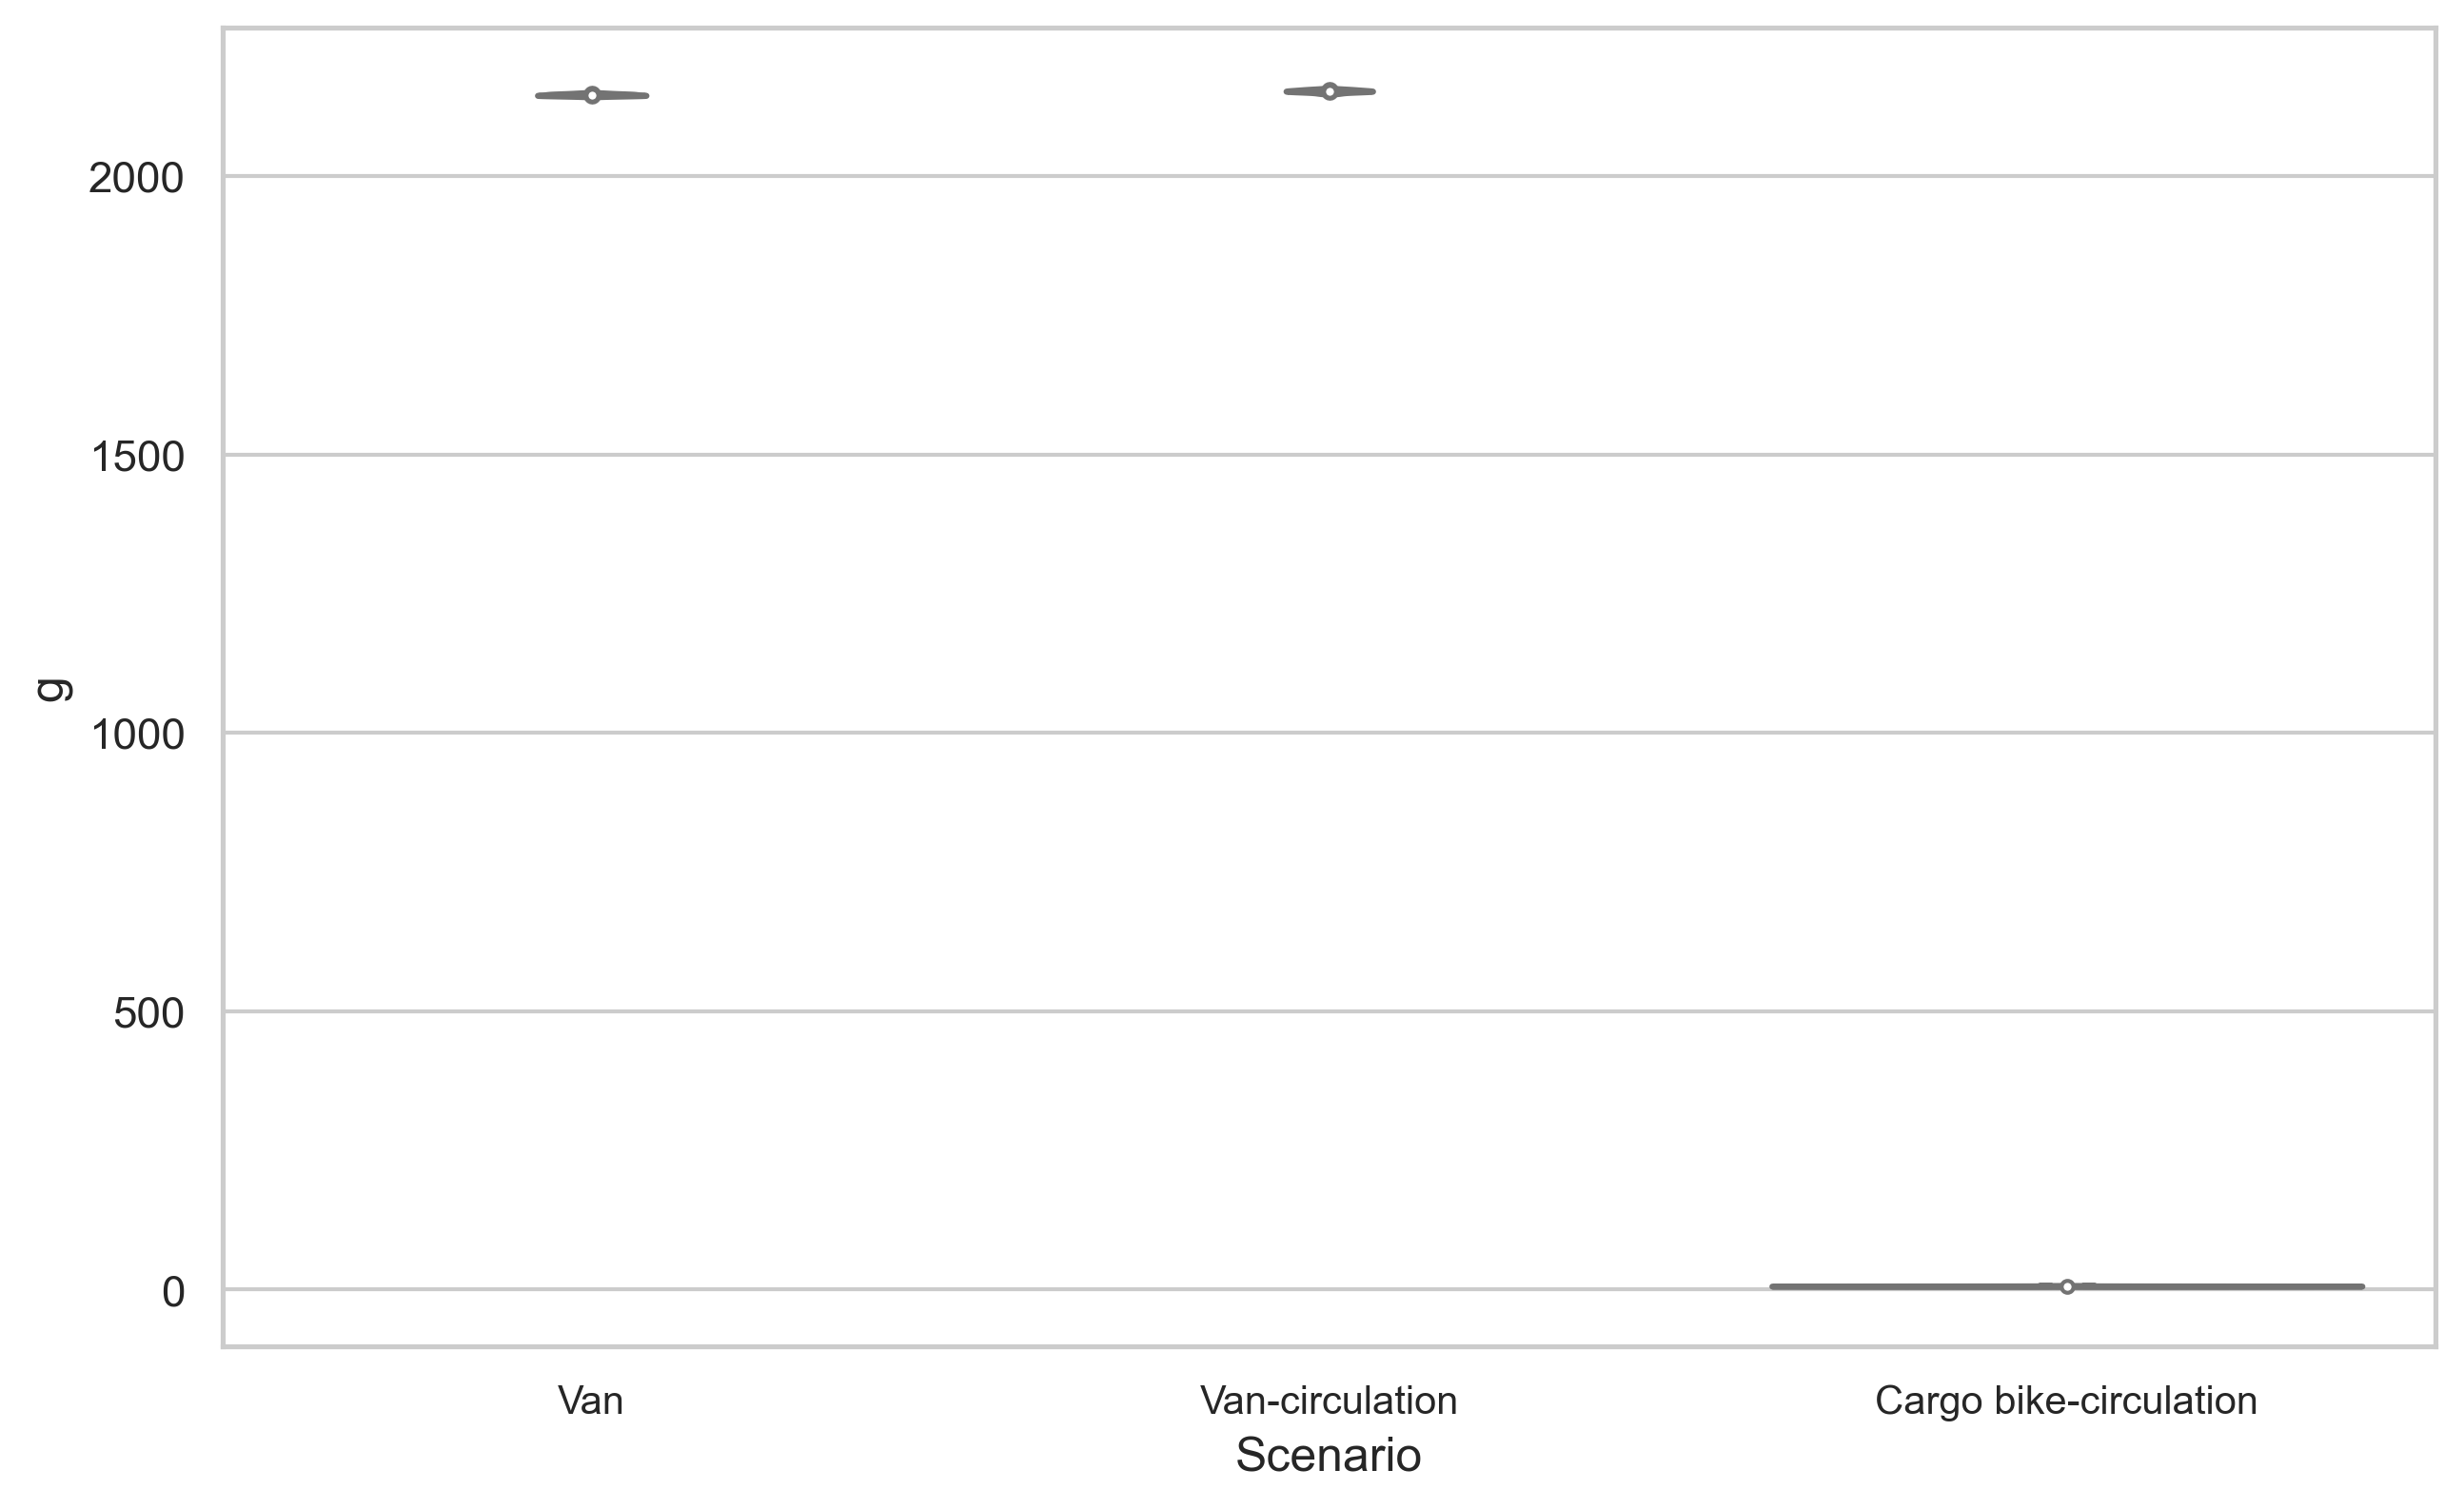

In [110]:
violin_plot(all_scenario_emissions, 'air_quality_pollutants', 'Scenario', 'g', save_path=None)

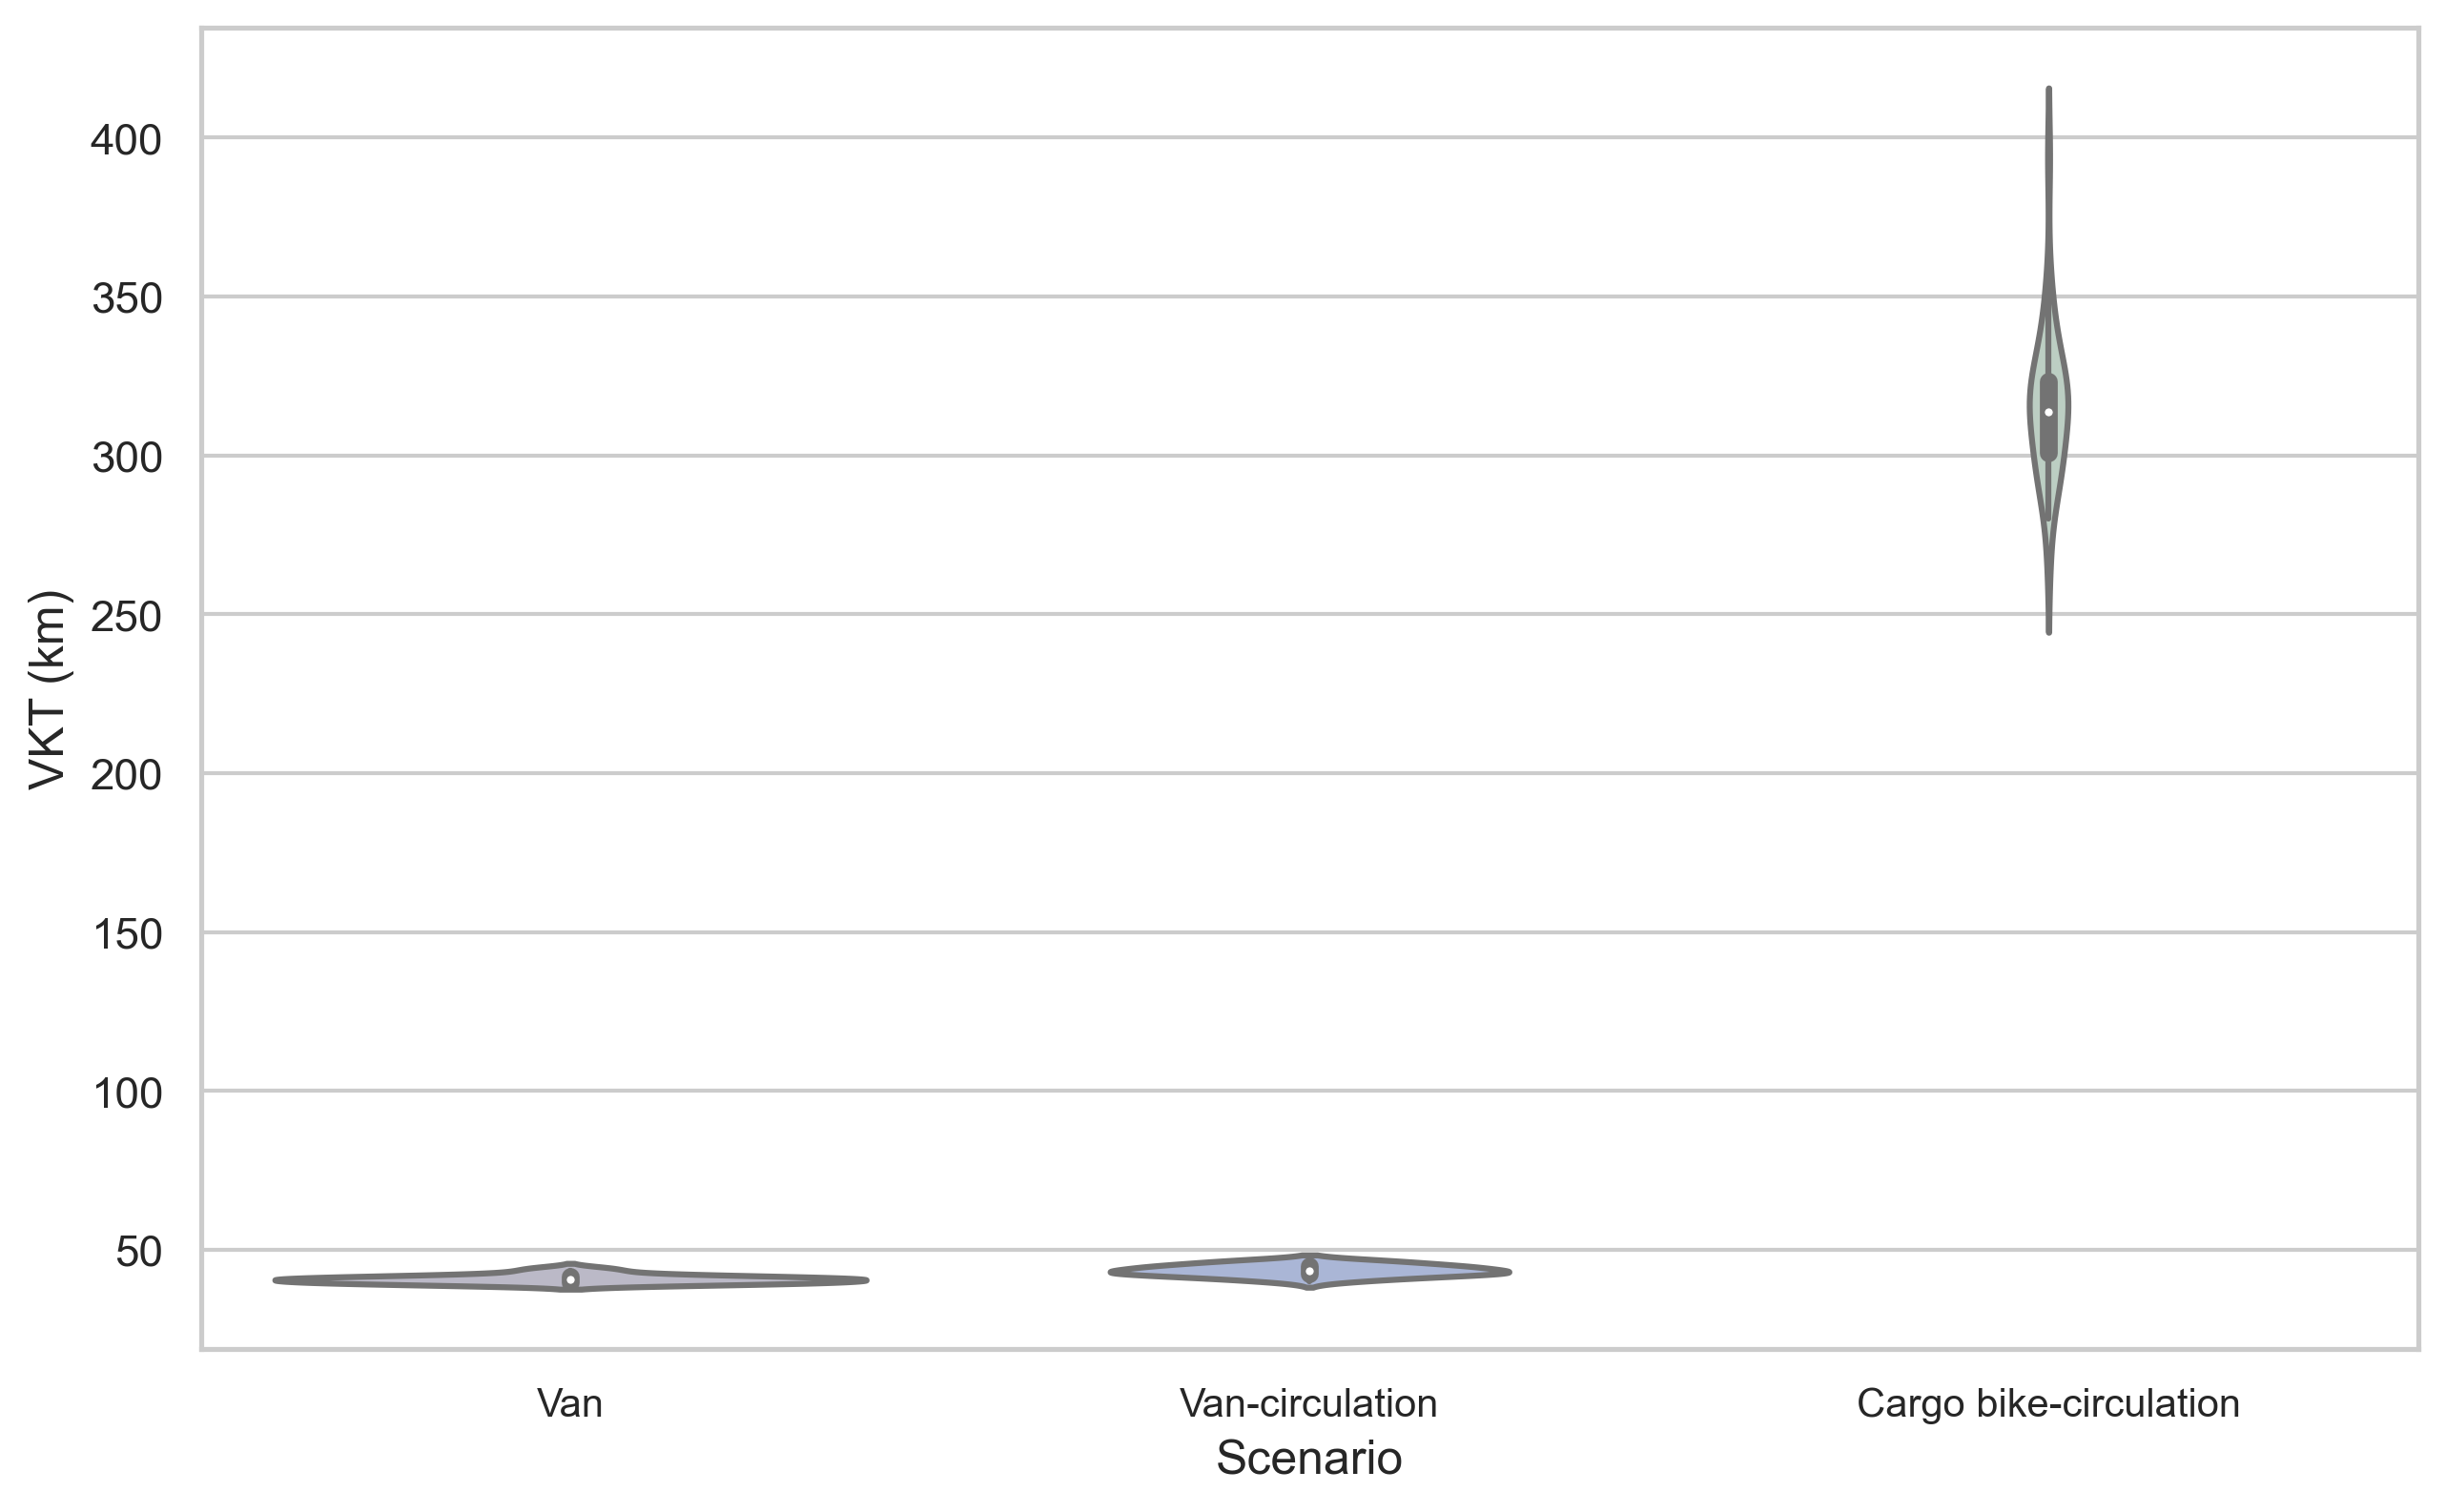

In [108]:
violin_plot(all_scenario_stats, 'travel_time_per_ton', 'Scenario', 'VKT (km)', save_path=None)

In [74]:
def multi_violin_box_scatter(data_dict, metric_kw, xlabel, ylabel, colors=None):
    if colors is None:
        colors = ['#B9B7C9', '#A3B3DD', '#B9D1C2']
    
    sns.set_theme(style="whitegrid")
    label_and_data = [(scenario_kw, dict_.get(metric_kw)) 
                      for scenario_kw, dict_ in data_dict.items()]
    labels = [tup[0] for tup in label_and_data]
    for label in labels:
        if label == 'basic':
            labels[labels.index(label)] = 'Van'
        elif label == 'van':
            labels[labels.index(label)] = 'Van-circulation'
        elif label == 'cb':
            labels[labels.index(label)] = 'Cargo bike-circulation'
        else:
            raise ValueError('Invalid scenario_kw')
    data = [tup[1] for tup in label_and_data]
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

    # 绘制小提琴图+设置样式
    for i in range(len(data)):
        parts = ax.violinplot(data[i], 
                               positions=[i], 
                               showmeans=False, 
                               showmedians=False, 
                               showextrema=False,
                               )
                               
        for pc in parts['bodies']:
            verts = pc.get_paths()[0].vertices
            verts[:, 0] = np.clip(verts[:, 0], i, np.inf)  # 限制小提琴图的左右边界位置
            pc.set_facecolor(colors[i])
            pc.set_edgecolor(None)
            pc.set_alpha(0.7)

    # 绘制箱线图+设置位置偏移
    box_positions = np.arange(len(data))
    ax.boxplot(data, positions=box_positions, widths=0.1, patch_artist=True,
               boxprops=dict(facecolor='snow', color='black'),
               whiskerprops=dict(color='black'), capprops=dict(color='black'),
               medianprops=dict(color='black', linewidth=2), zorder=2)

    # 绘制散点图
    for i, d in enumerate(data):
        jittered_x = np.random.normal(loc=i-0.1, scale=0.01, size=len(d))  # 添加抖动
        ax.scatter(jittered_x, d, alpha=0.8, color=colors[i], zorder=1, s=2)

    ax.set_xticks(np.arange(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    plt.show()

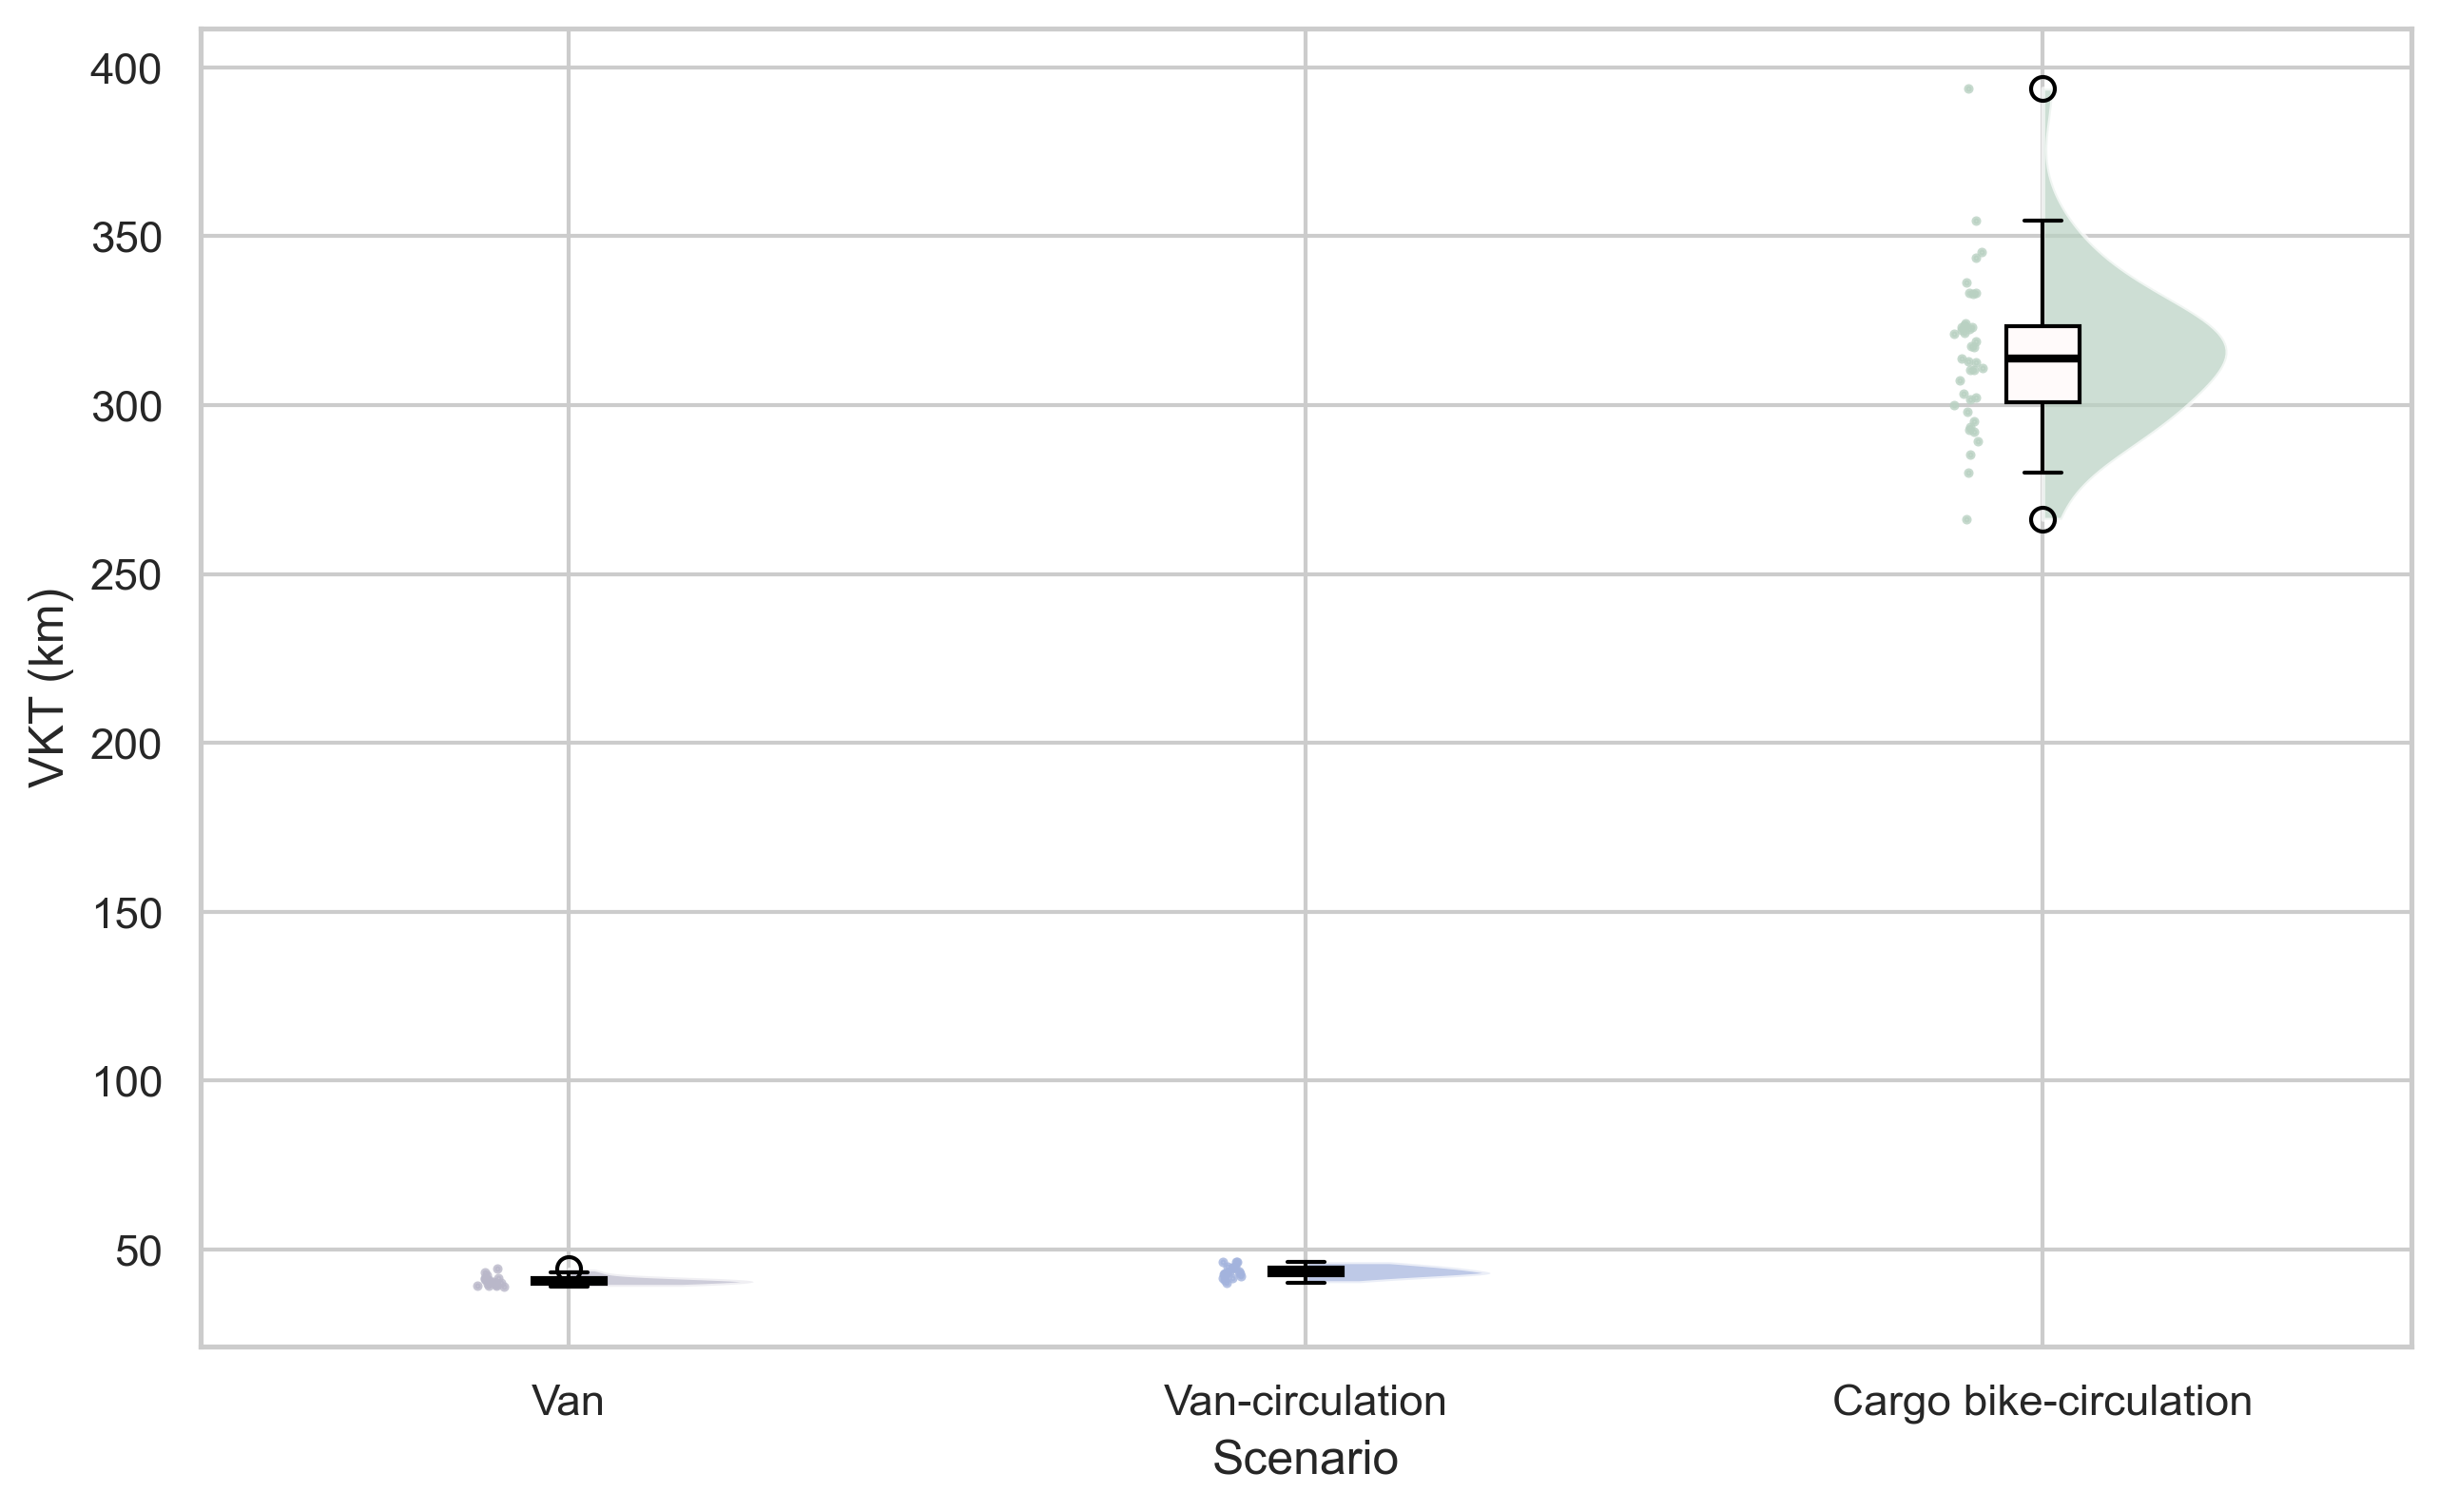

In [76]:
multi_violin_box_scatter( all_scenario_stats, 'travel_time_per_ton', 'Scenario', 'VKT (km)')

In [119]:
def plot_stat_comparison(
    bike_summary,
    car_summary,
    no_policy_summary,
    xlabel,
    filename=None,
    colors=["darkgrey", "steelblue", "#A5D6A7"],
    alphas=[0.8, 0.6, 0.8],
    figure_size=(10, 6),
):
    fig, ax = plt.subplots(figsize=figure_size, dpi=300)
    min_val = min(bike_summary.min(), car_summary.min(), no_policy_summary.min())
    max_val = max(bike_summary.max(), car_summary.max(), no_policy_summary.max())

    bins = np.linspace(min_val, max_val, 11)

    plt.hist(
        no_policy_summary, bins=bins, color=colors[0], alpha=alphas[0], label="Van"
    )
    plt.hist(
        car_summary,
        bins=bins,
        color=colors[1],
        alpha=alphas[1],
        label="Van-Circulation",
    )
    plt.hist(
        bike_summary,
        bins=bins,
        color=colors[2],
        alpha=alphas[2],
        label="Cargo Bike-Circulation",
    )

    # Hide the right and top spines
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)

    plt.xlabel(xlabel, fontsize=12, fontweight="bold")
    plt.ylabel("Density", fontsize=12, fontweight="bold")
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    # plt.savefig(figure_folder + filename)
    plt.show()

In [141]:
def plot_stat_comparison_two_groups(
    car_summary,
    no_policy_summary,
    xlabel,
    filename=None,
    colors=["darkgrey", "steelblue"],
    alphas=[0.8, 0.6],
    figure_size=(10, 6),
):
    fig, ax = plt.subplots(figsize=figure_size, dpi=300)
    min_val = min(car_summary.min(), no_policy_summary.min())
    max_val = max(car_summary.max(), no_policy_summary.max())

    bins = np.linspace(min_val, max_val, 11)

    plt.hist(
        no_policy_summary, bins=bins, color=colors[0], alpha=alphas[0], label="Van"
    )
    plt.hist(
        car_summary,
        bins=bins,
        color=colors[1],
        alpha=alphas[1],
        label="Van-Circulation",
    )

    # Hide the right and top spines
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)

    plt.xlabel(xlabel, fontsize=12, fontweight="bold")
    plt.ylabel("Density", fontsize=12, fontweight="bold")
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    # plt.savefig(figure_folder + filename)
    plt.show()

## VKT

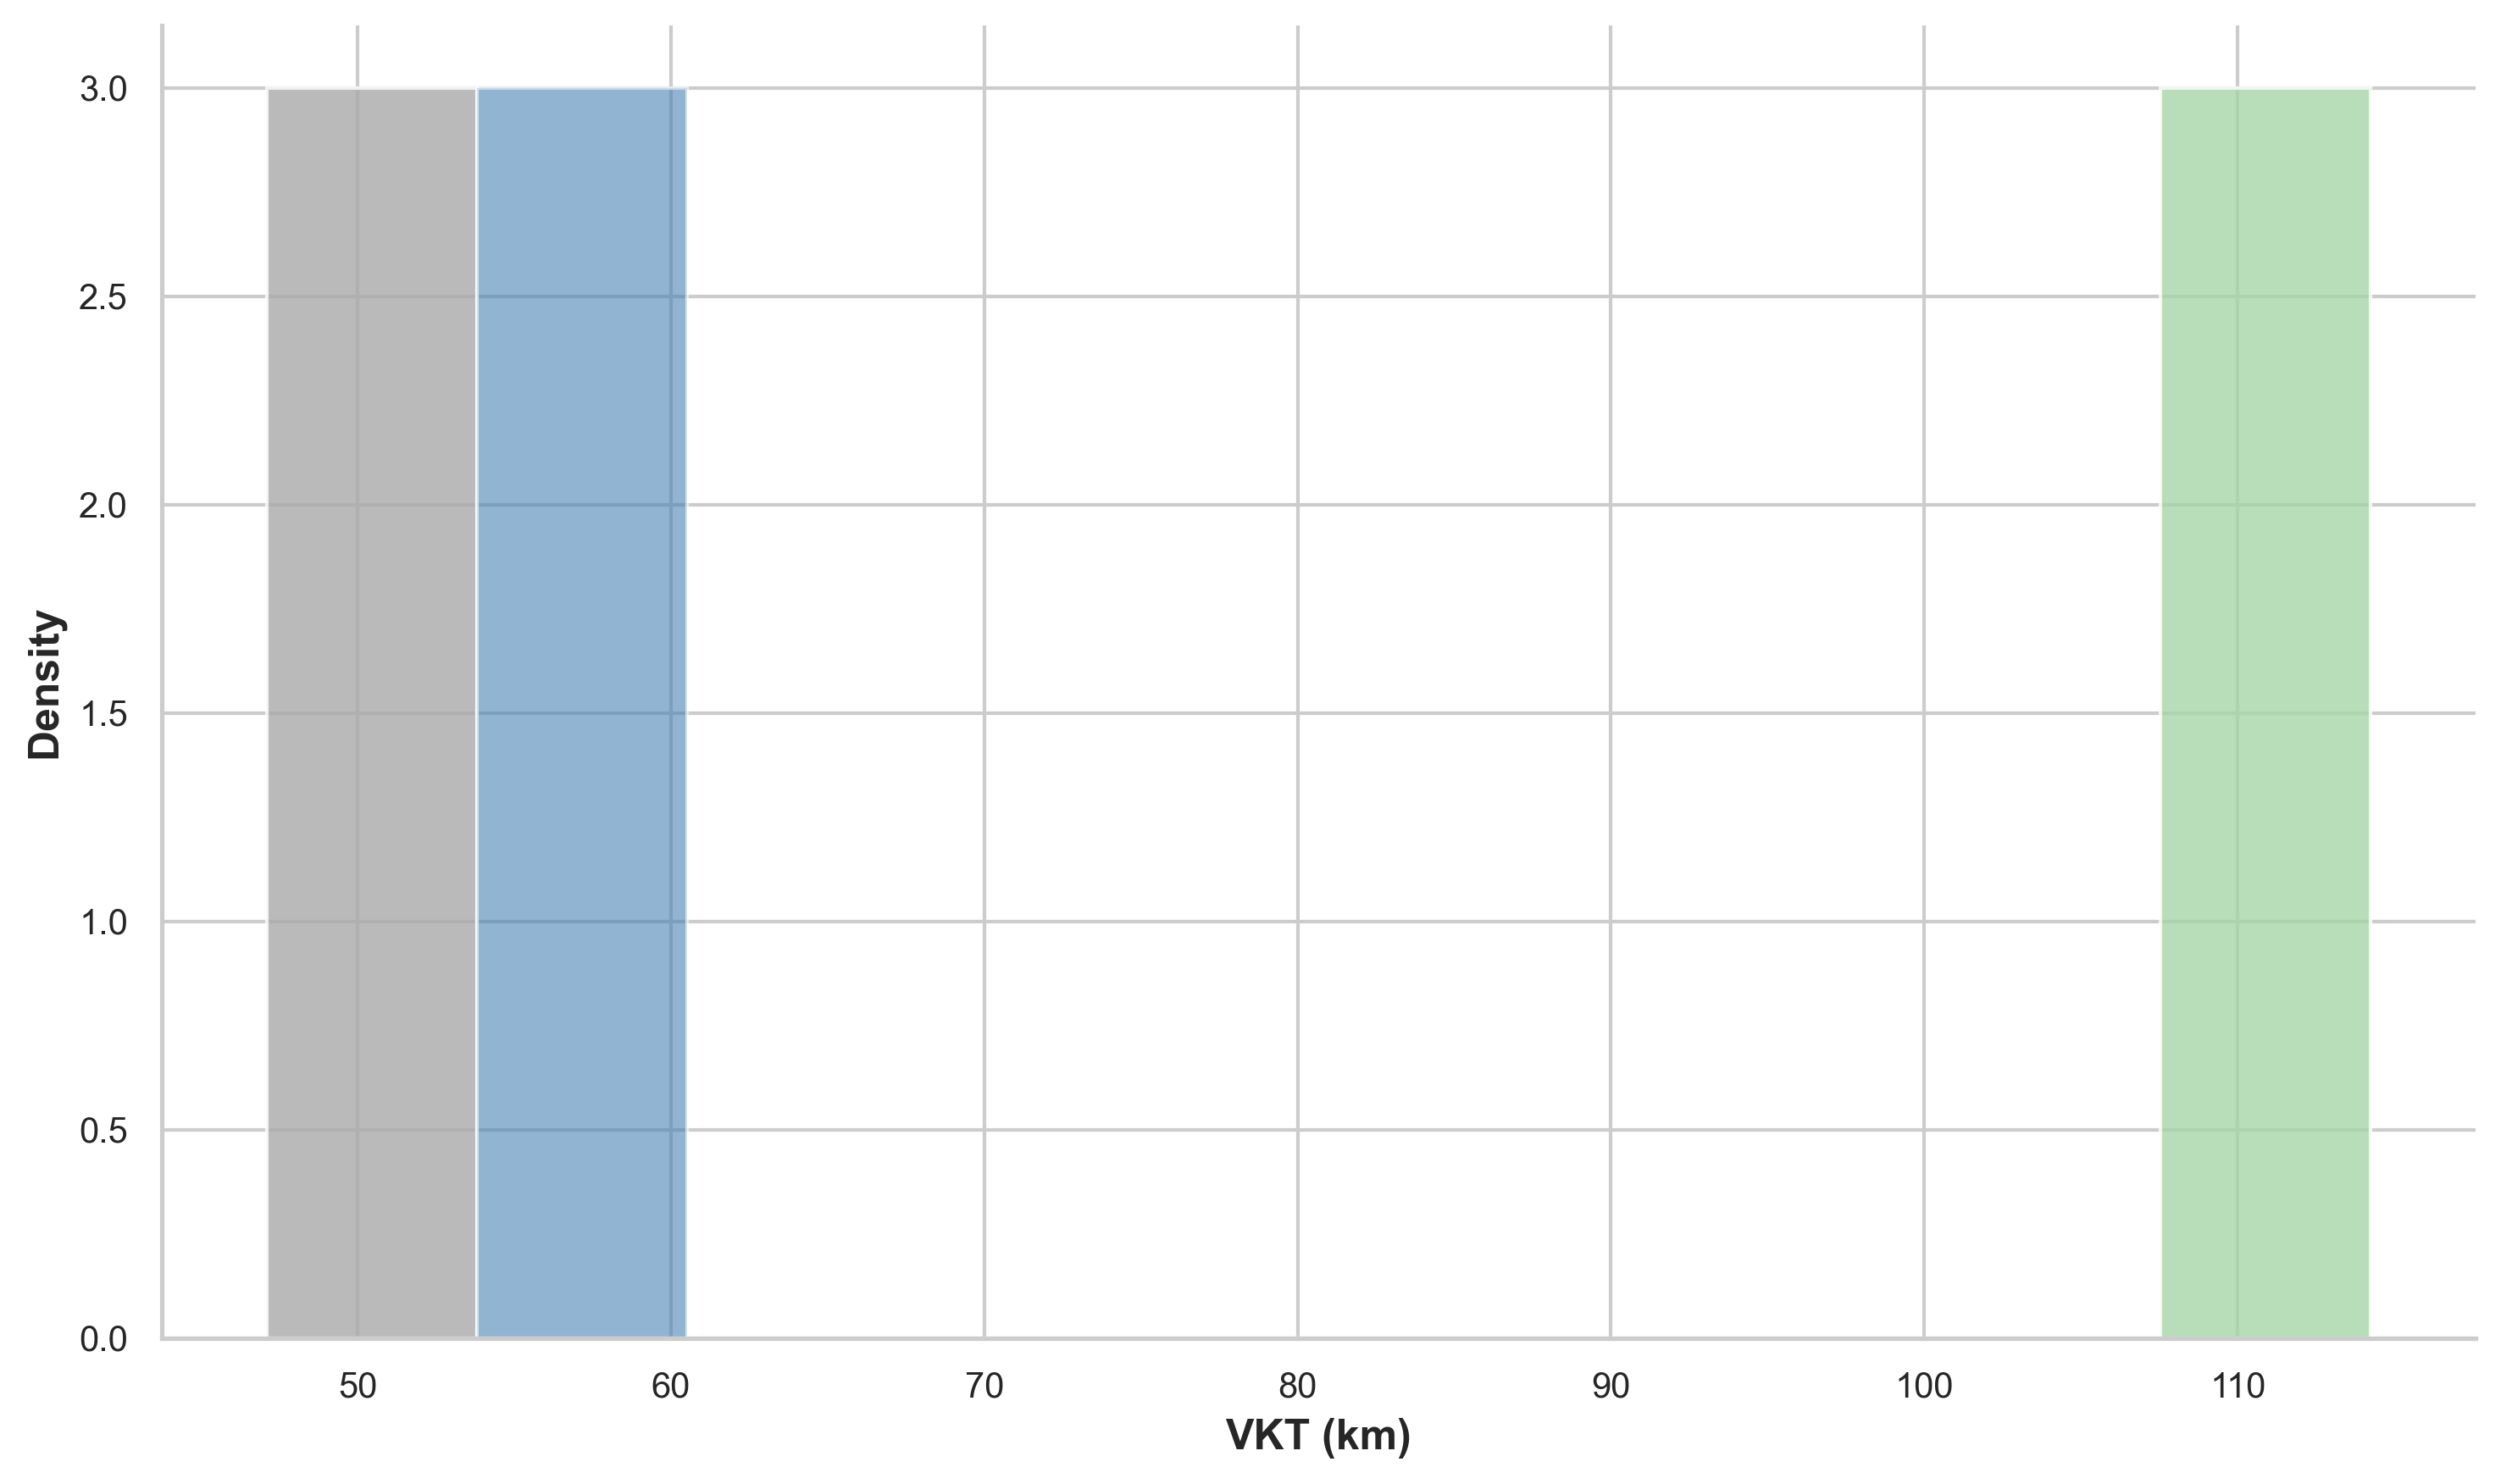

In [154]:
metric = 'vkt'
plot_stat_comparison(
    no_policy_summary=np.array(all_scenario_stats['basic'][metric]),
    car_summary=np.array(all_scenario_stats['van'][metric]),
    bike_summary=np.array(all_scenario_stats['cb'][metric]),
    xlabel='VKT (km)',
)

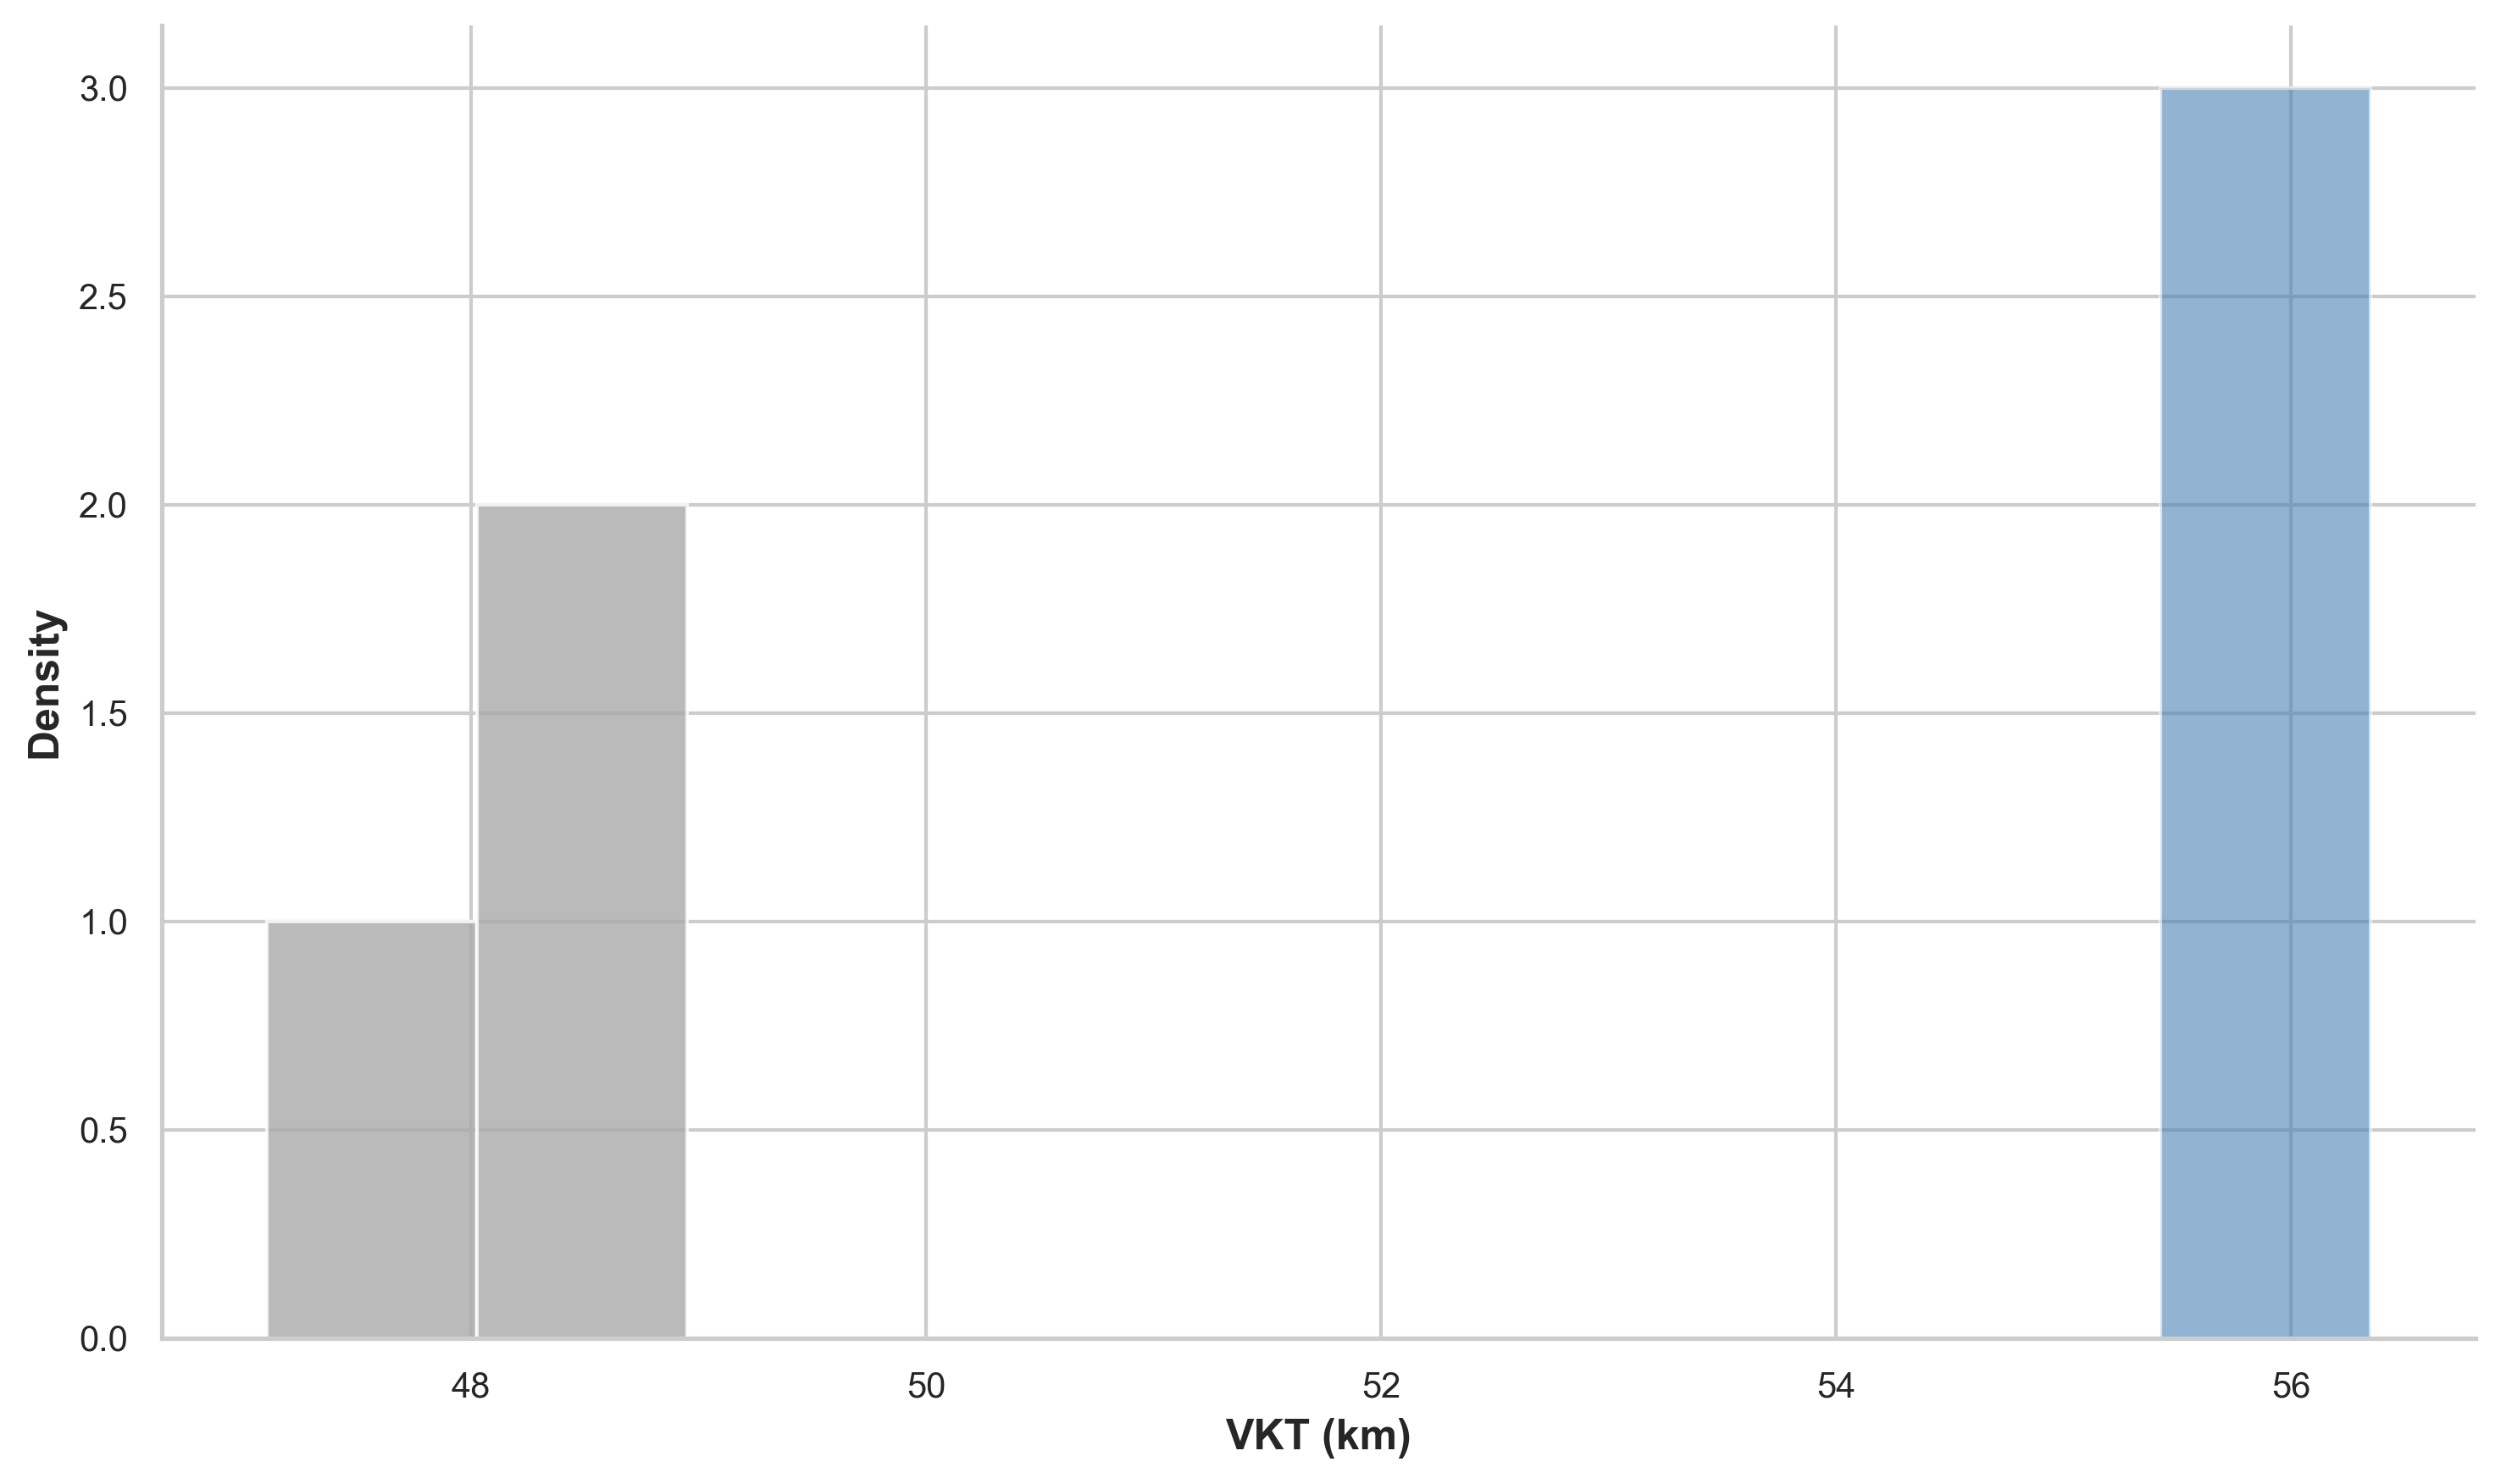

In [155]:
metric = 'vkt'
plot_stat_comparison_two_groups(
    no_policy_summary=np.array(all_scenario_stats['basic'][metric]),
    car_summary=np.array(all_scenario_stats['van'][metric]),
    xlabel='VKT (km)',
)

## travel time per ton

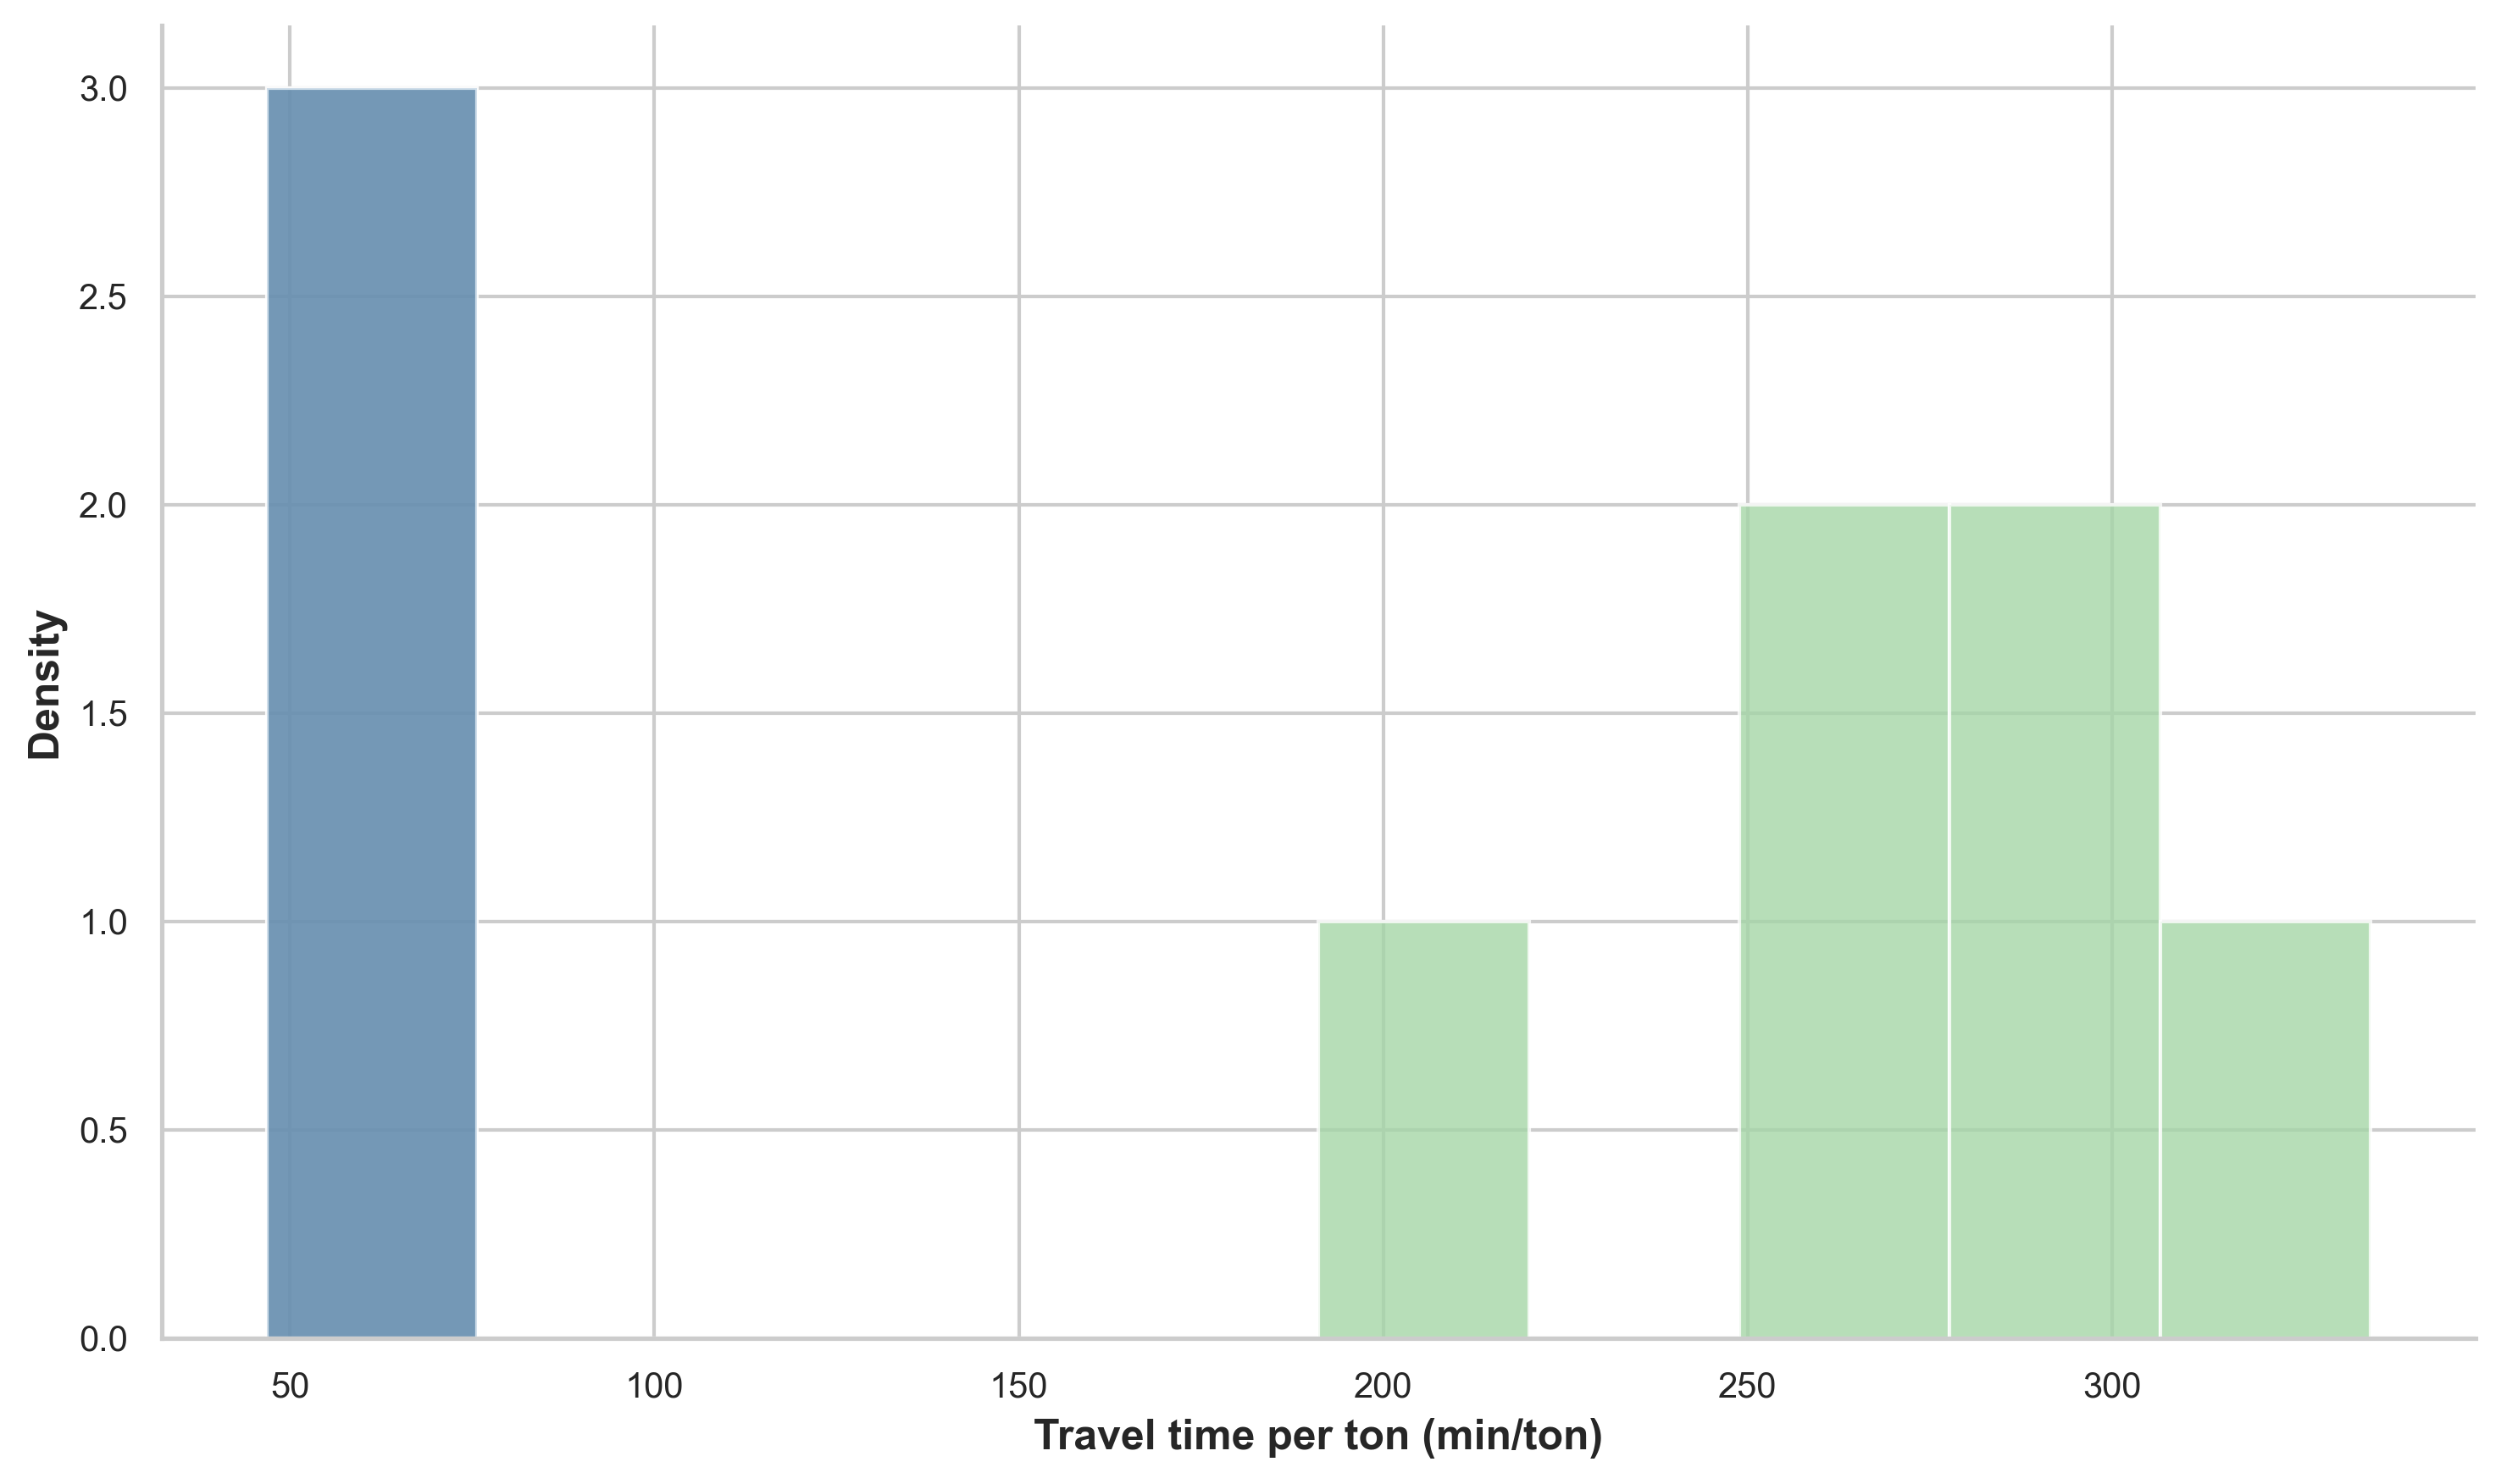

In [156]:
metric = 'travel_time_per_ton'
plot_stat_comparison(
    no_policy_summary=np.array(all_scenario_stats['basic'][metric]),
    car_summary=np.array(all_scenario_stats['van'][metric]),
    bike_summary=np.array(all_scenario_stats['cb'][metric]),
    xlabel='Travel time per ton (min/ton)',
)

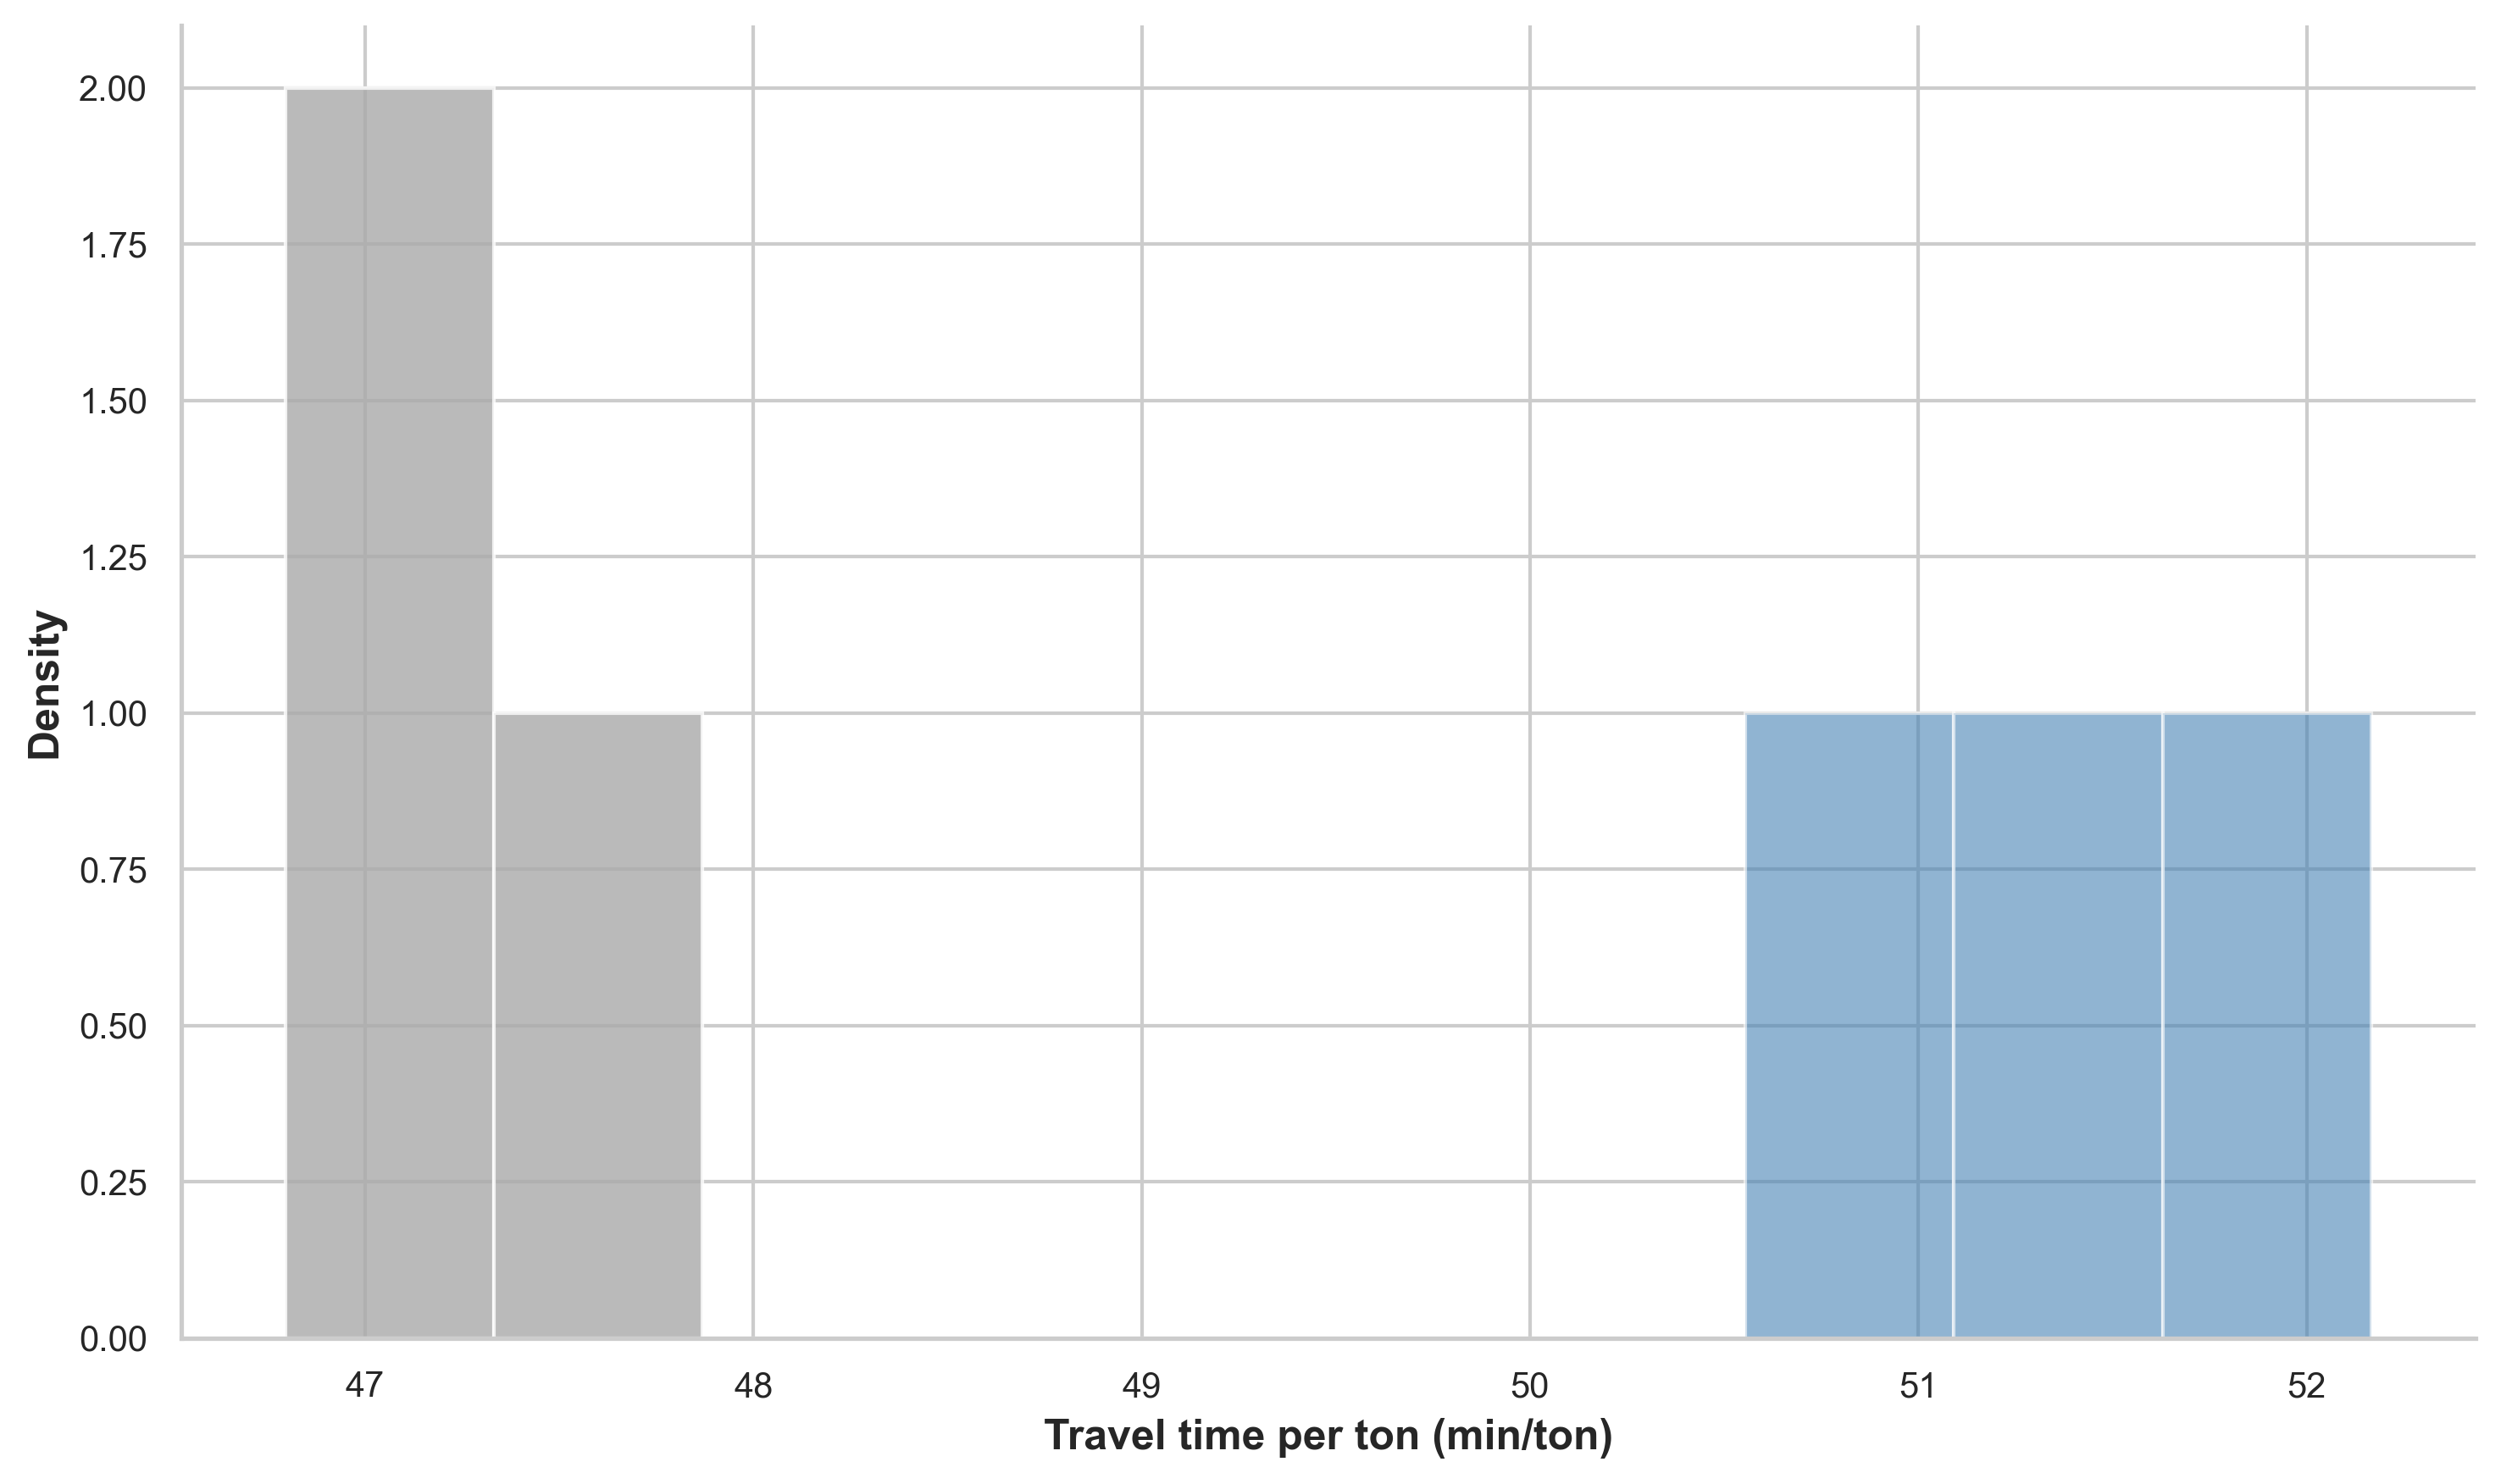

In [157]:
metric = 'travel_time_per_ton'
plot_stat_comparison_two_groups(
    no_policy_summary=np.array(all_scenario_stats['basic'][metric]),
    car_summary=np.array(all_scenario_stats['van'][metric]),
    xlabel='Travel time per ton (min/ton)',
)

## VKT per ton

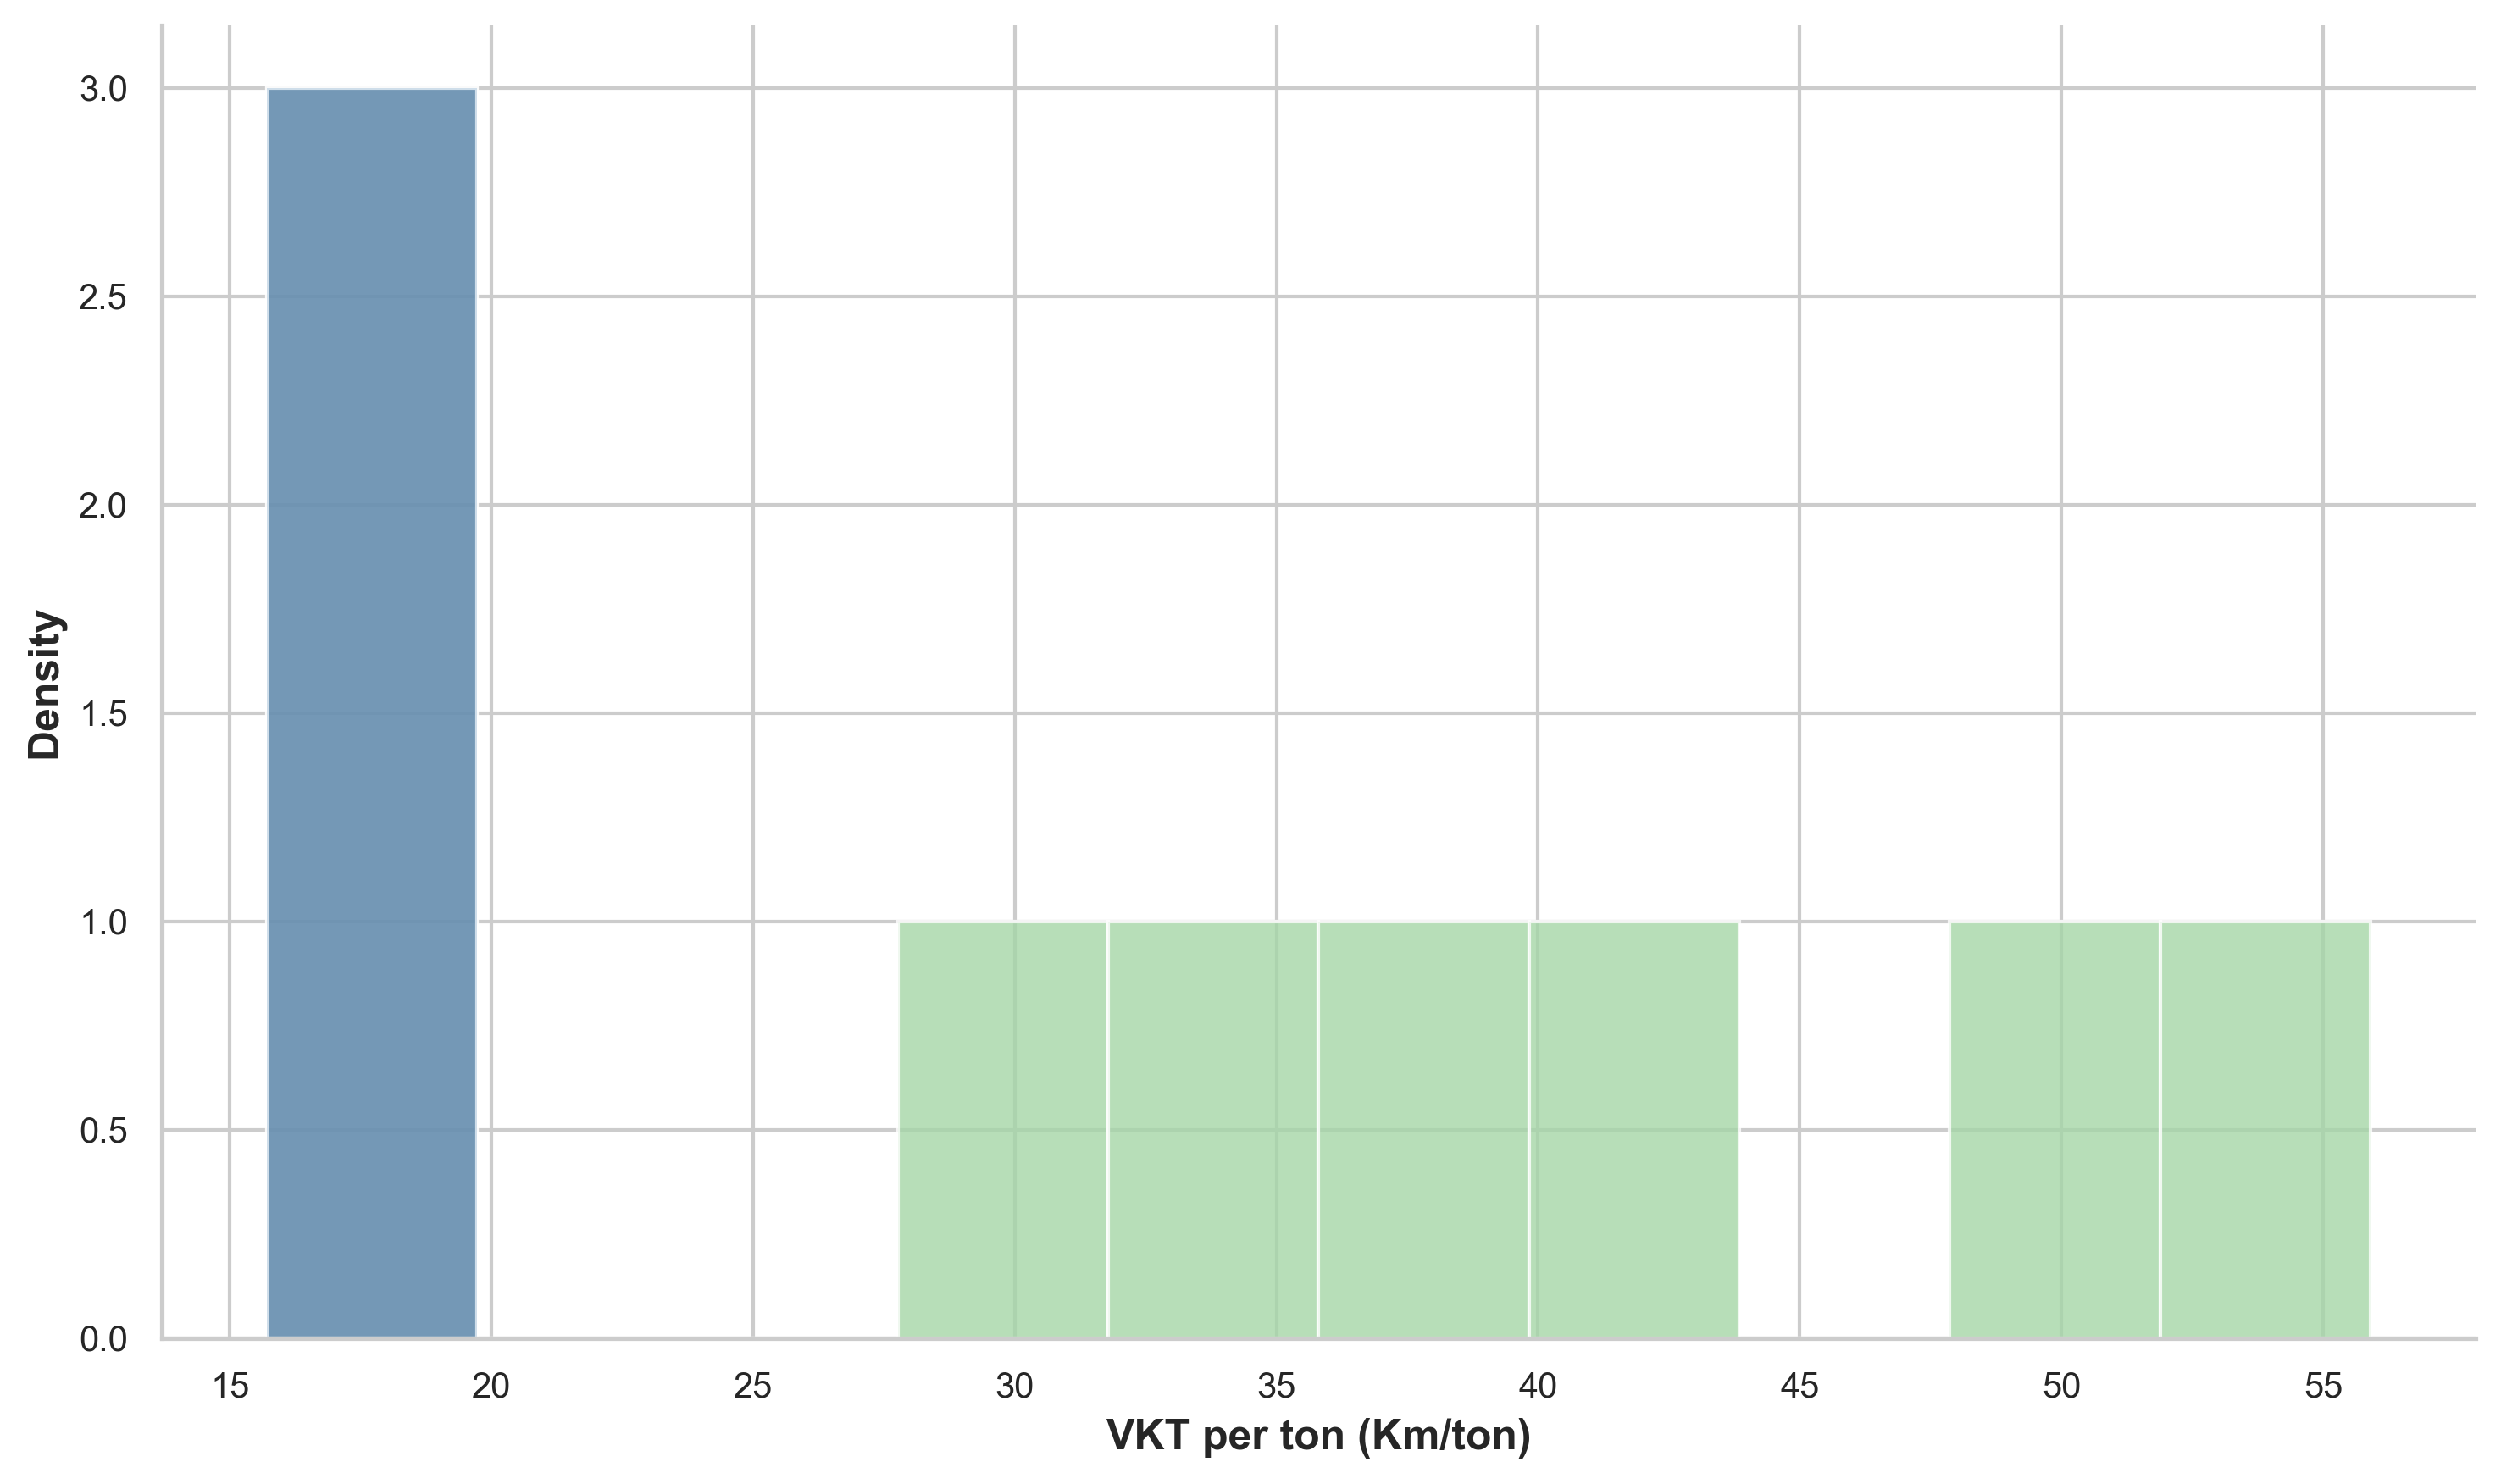

In [158]:
metric = 'vkt_per_ton'
plot_stat_comparison(
    no_policy_summary=np.array(all_scenario_stats['basic'][metric]),
    car_summary=np.array(all_scenario_stats['van'][metric]),
    bike_summary=np.array(all_scenario_stats['cb'][metric]),
    xlabel='VKT per ton (Km/ton)',
)

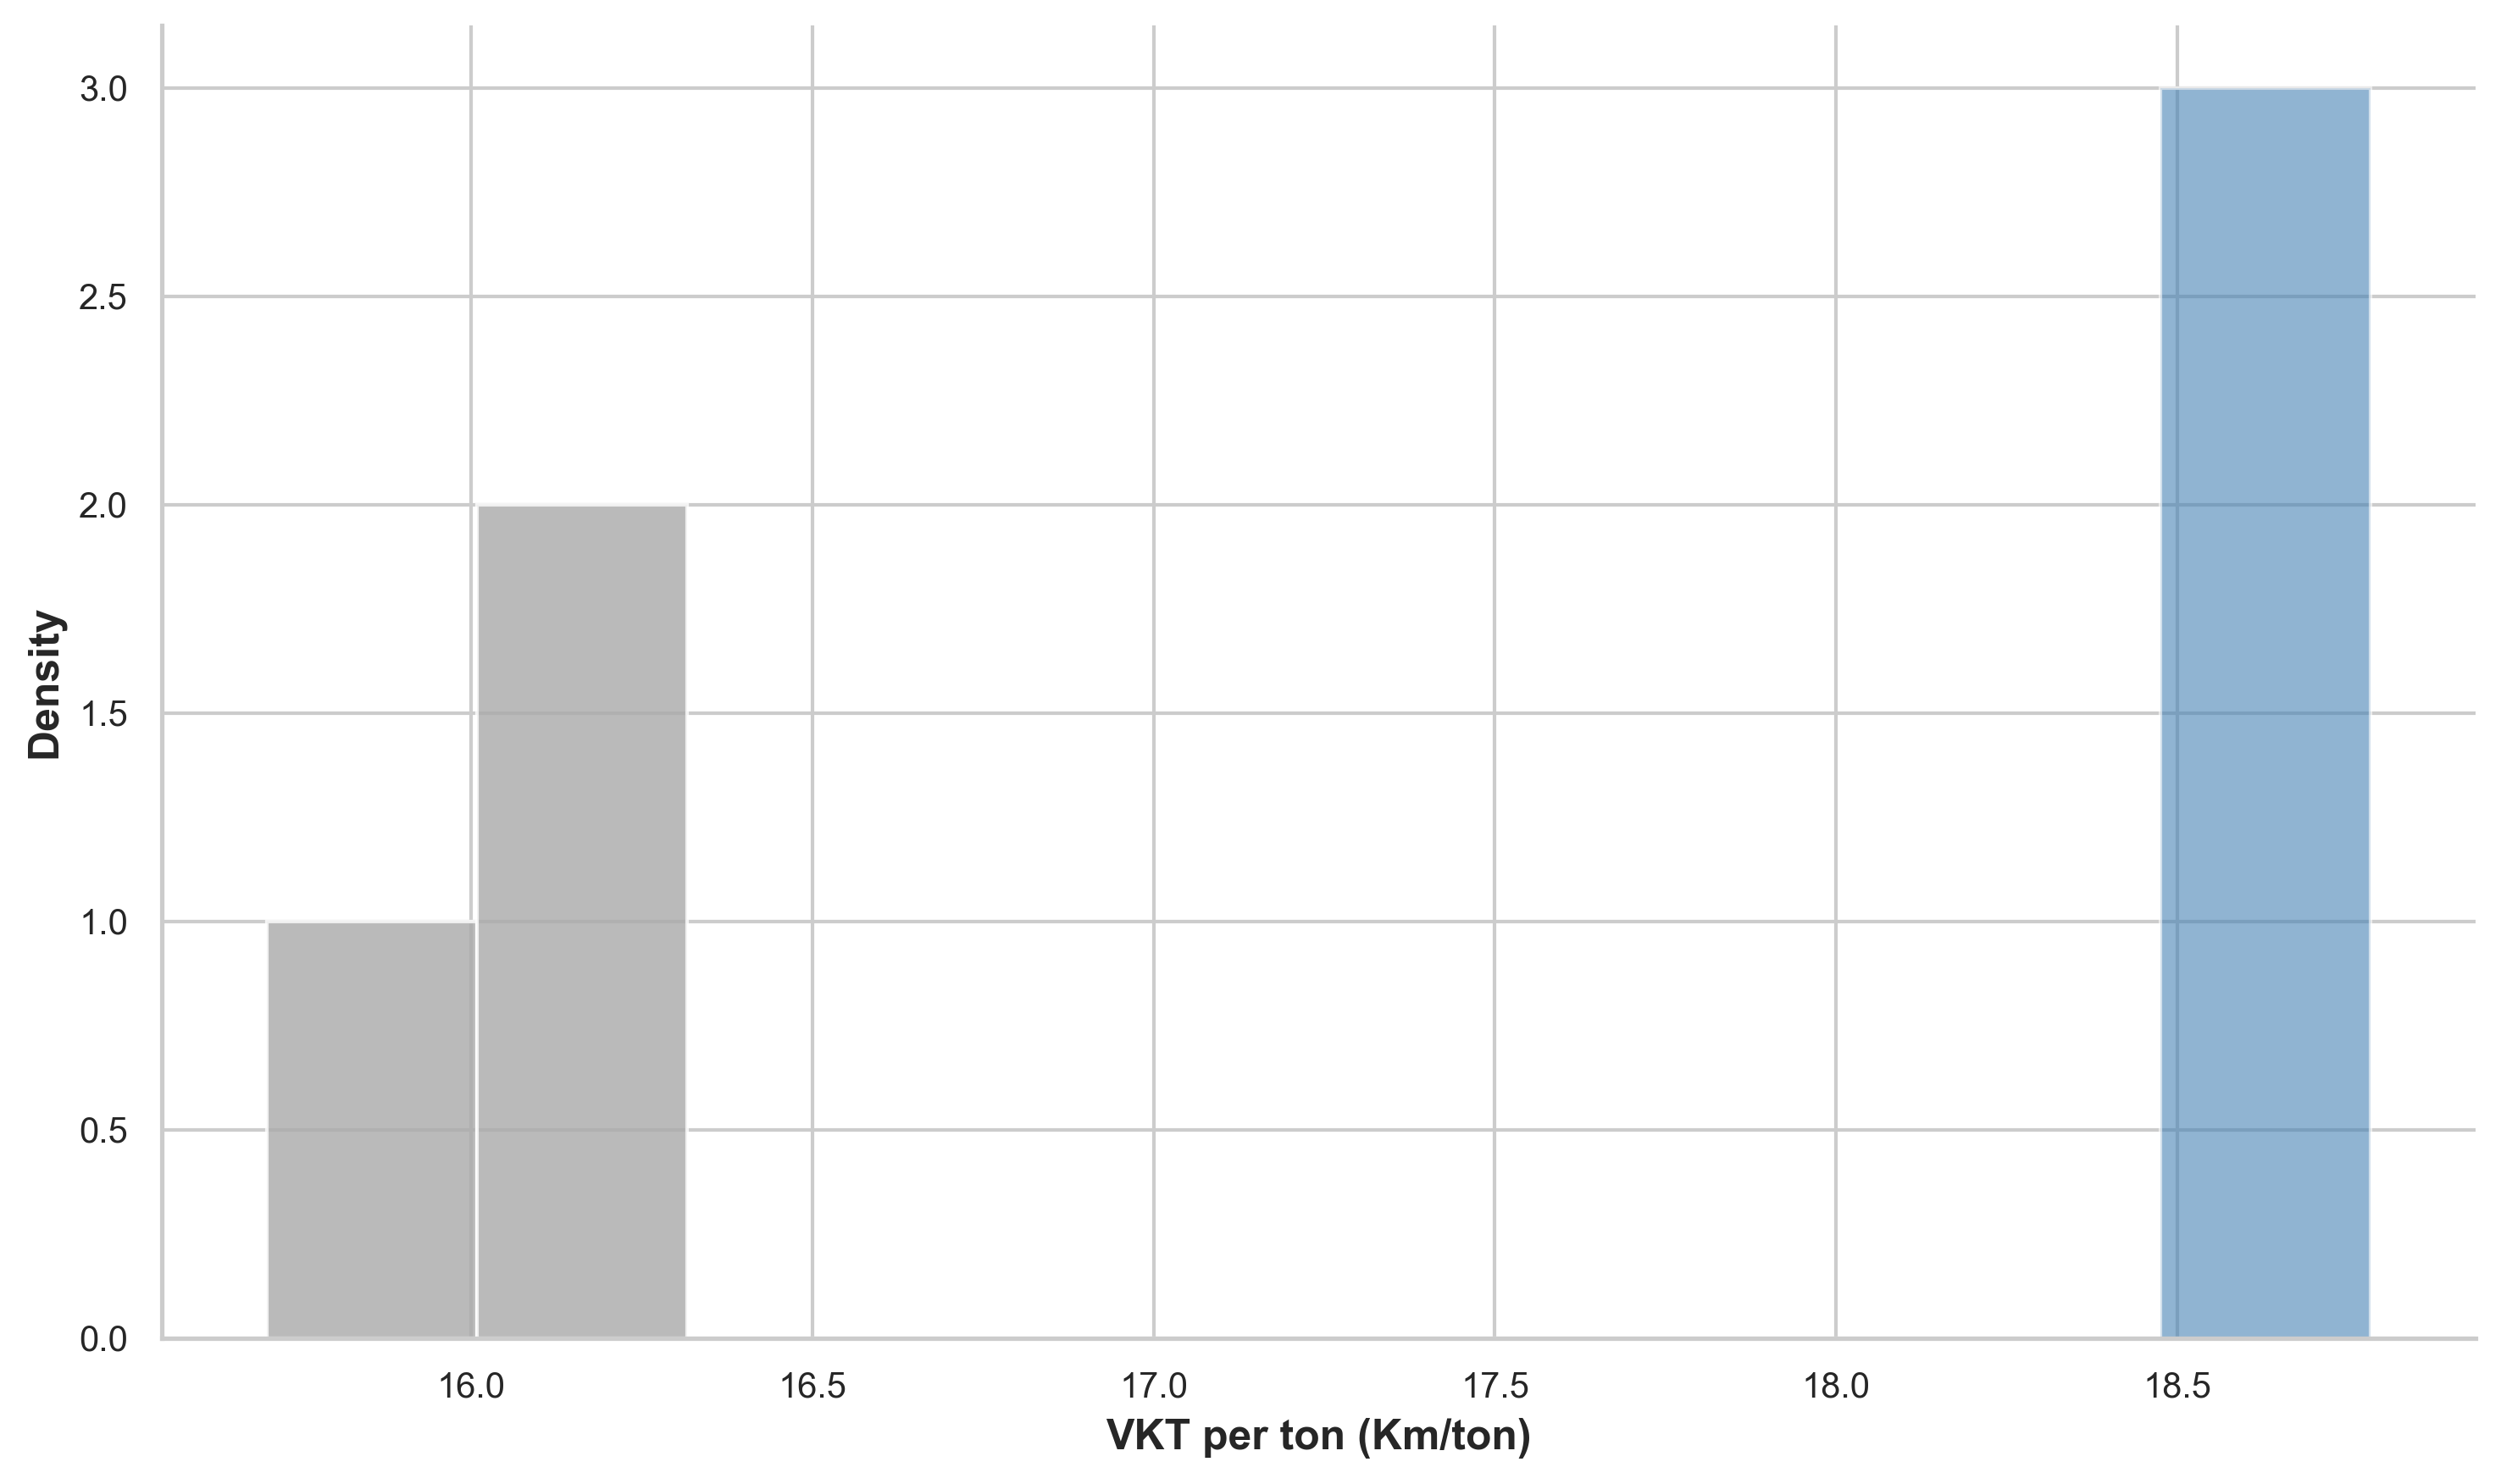

In [159]:
metric = 'vkt_per_ton'
plot_stat_comparison_two_groups(
    no_policy_summary=np.array(all_scenario_stats['basic'][metric]),
    car_summary=np.array(all_scenario_stats['van'][metric]),
    xlabel='VKT per ton (Km/ton)',
)

## CO2e

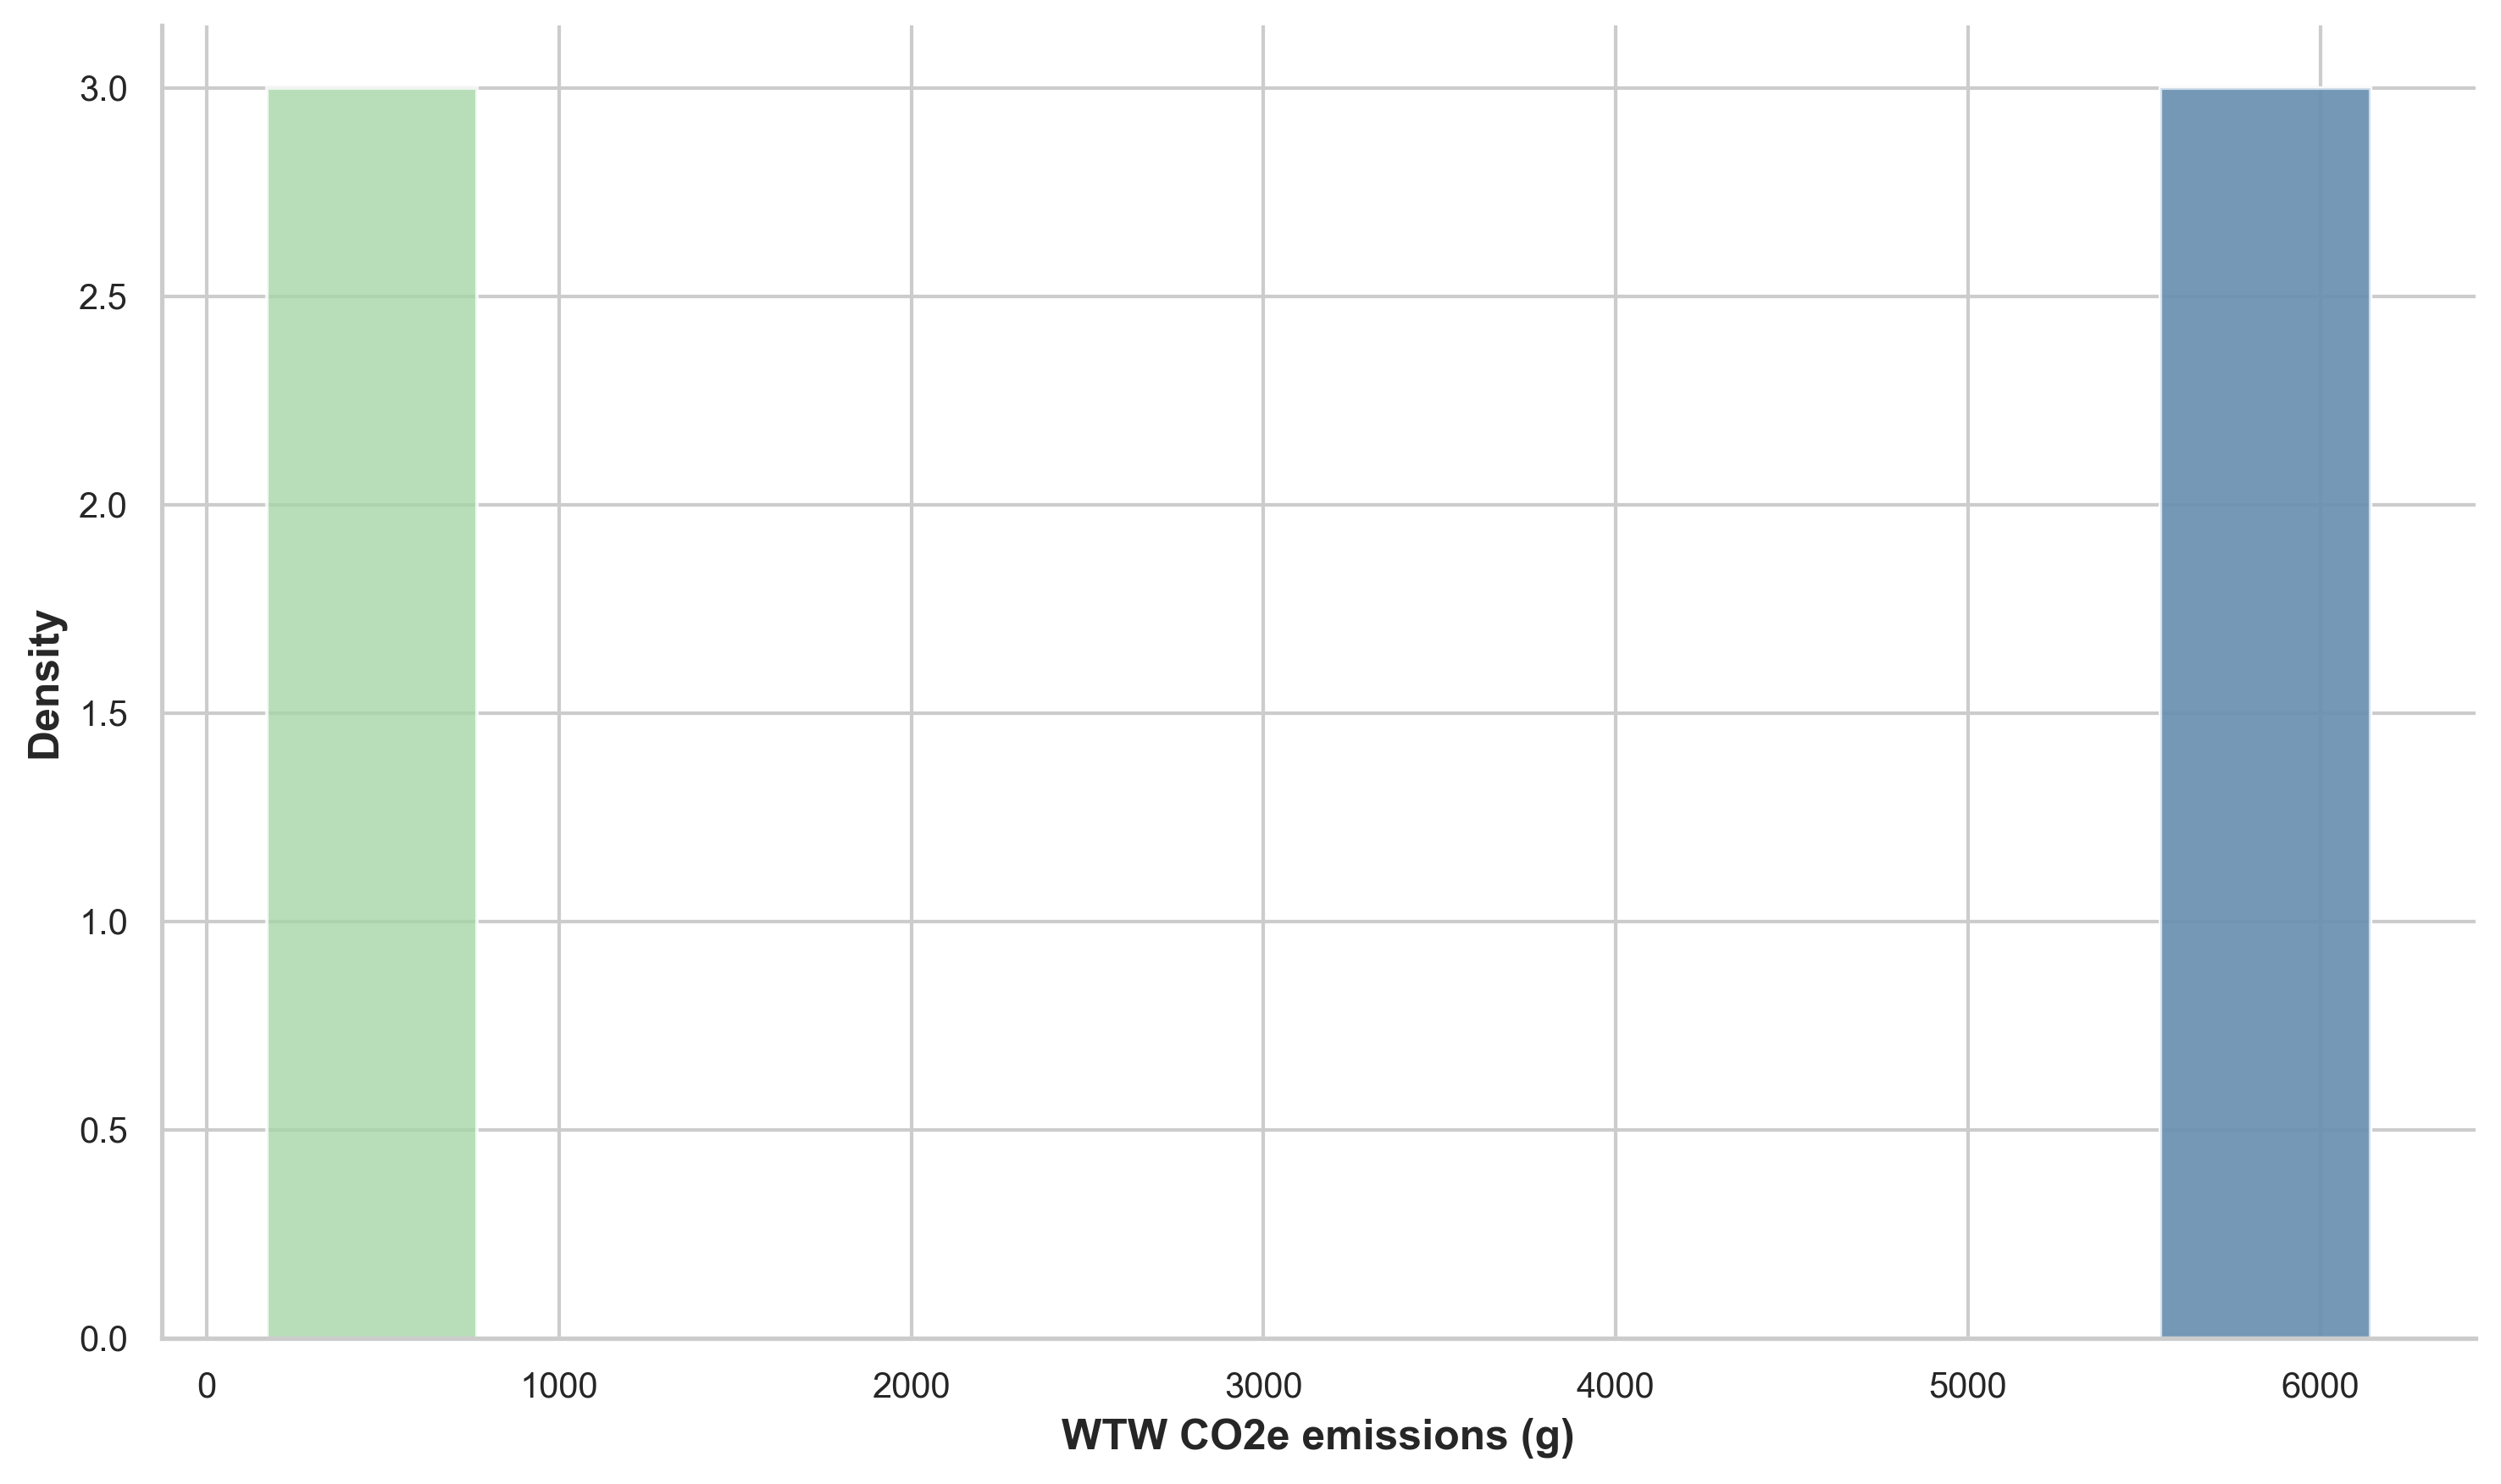

In [160]:
metric = pollutants.CO2e
plot_stat_comparison(
    no_policy_summary=np.array(all_scenario_emissions['basic'][metric]),
    car_summary=np.array(all_scenario_emissions['van'][metric]),
    bike_summary=np.array(all_scenario_emissions['cb'][metric]),
    xlabel='WTW CO2e emissions (g)',
)

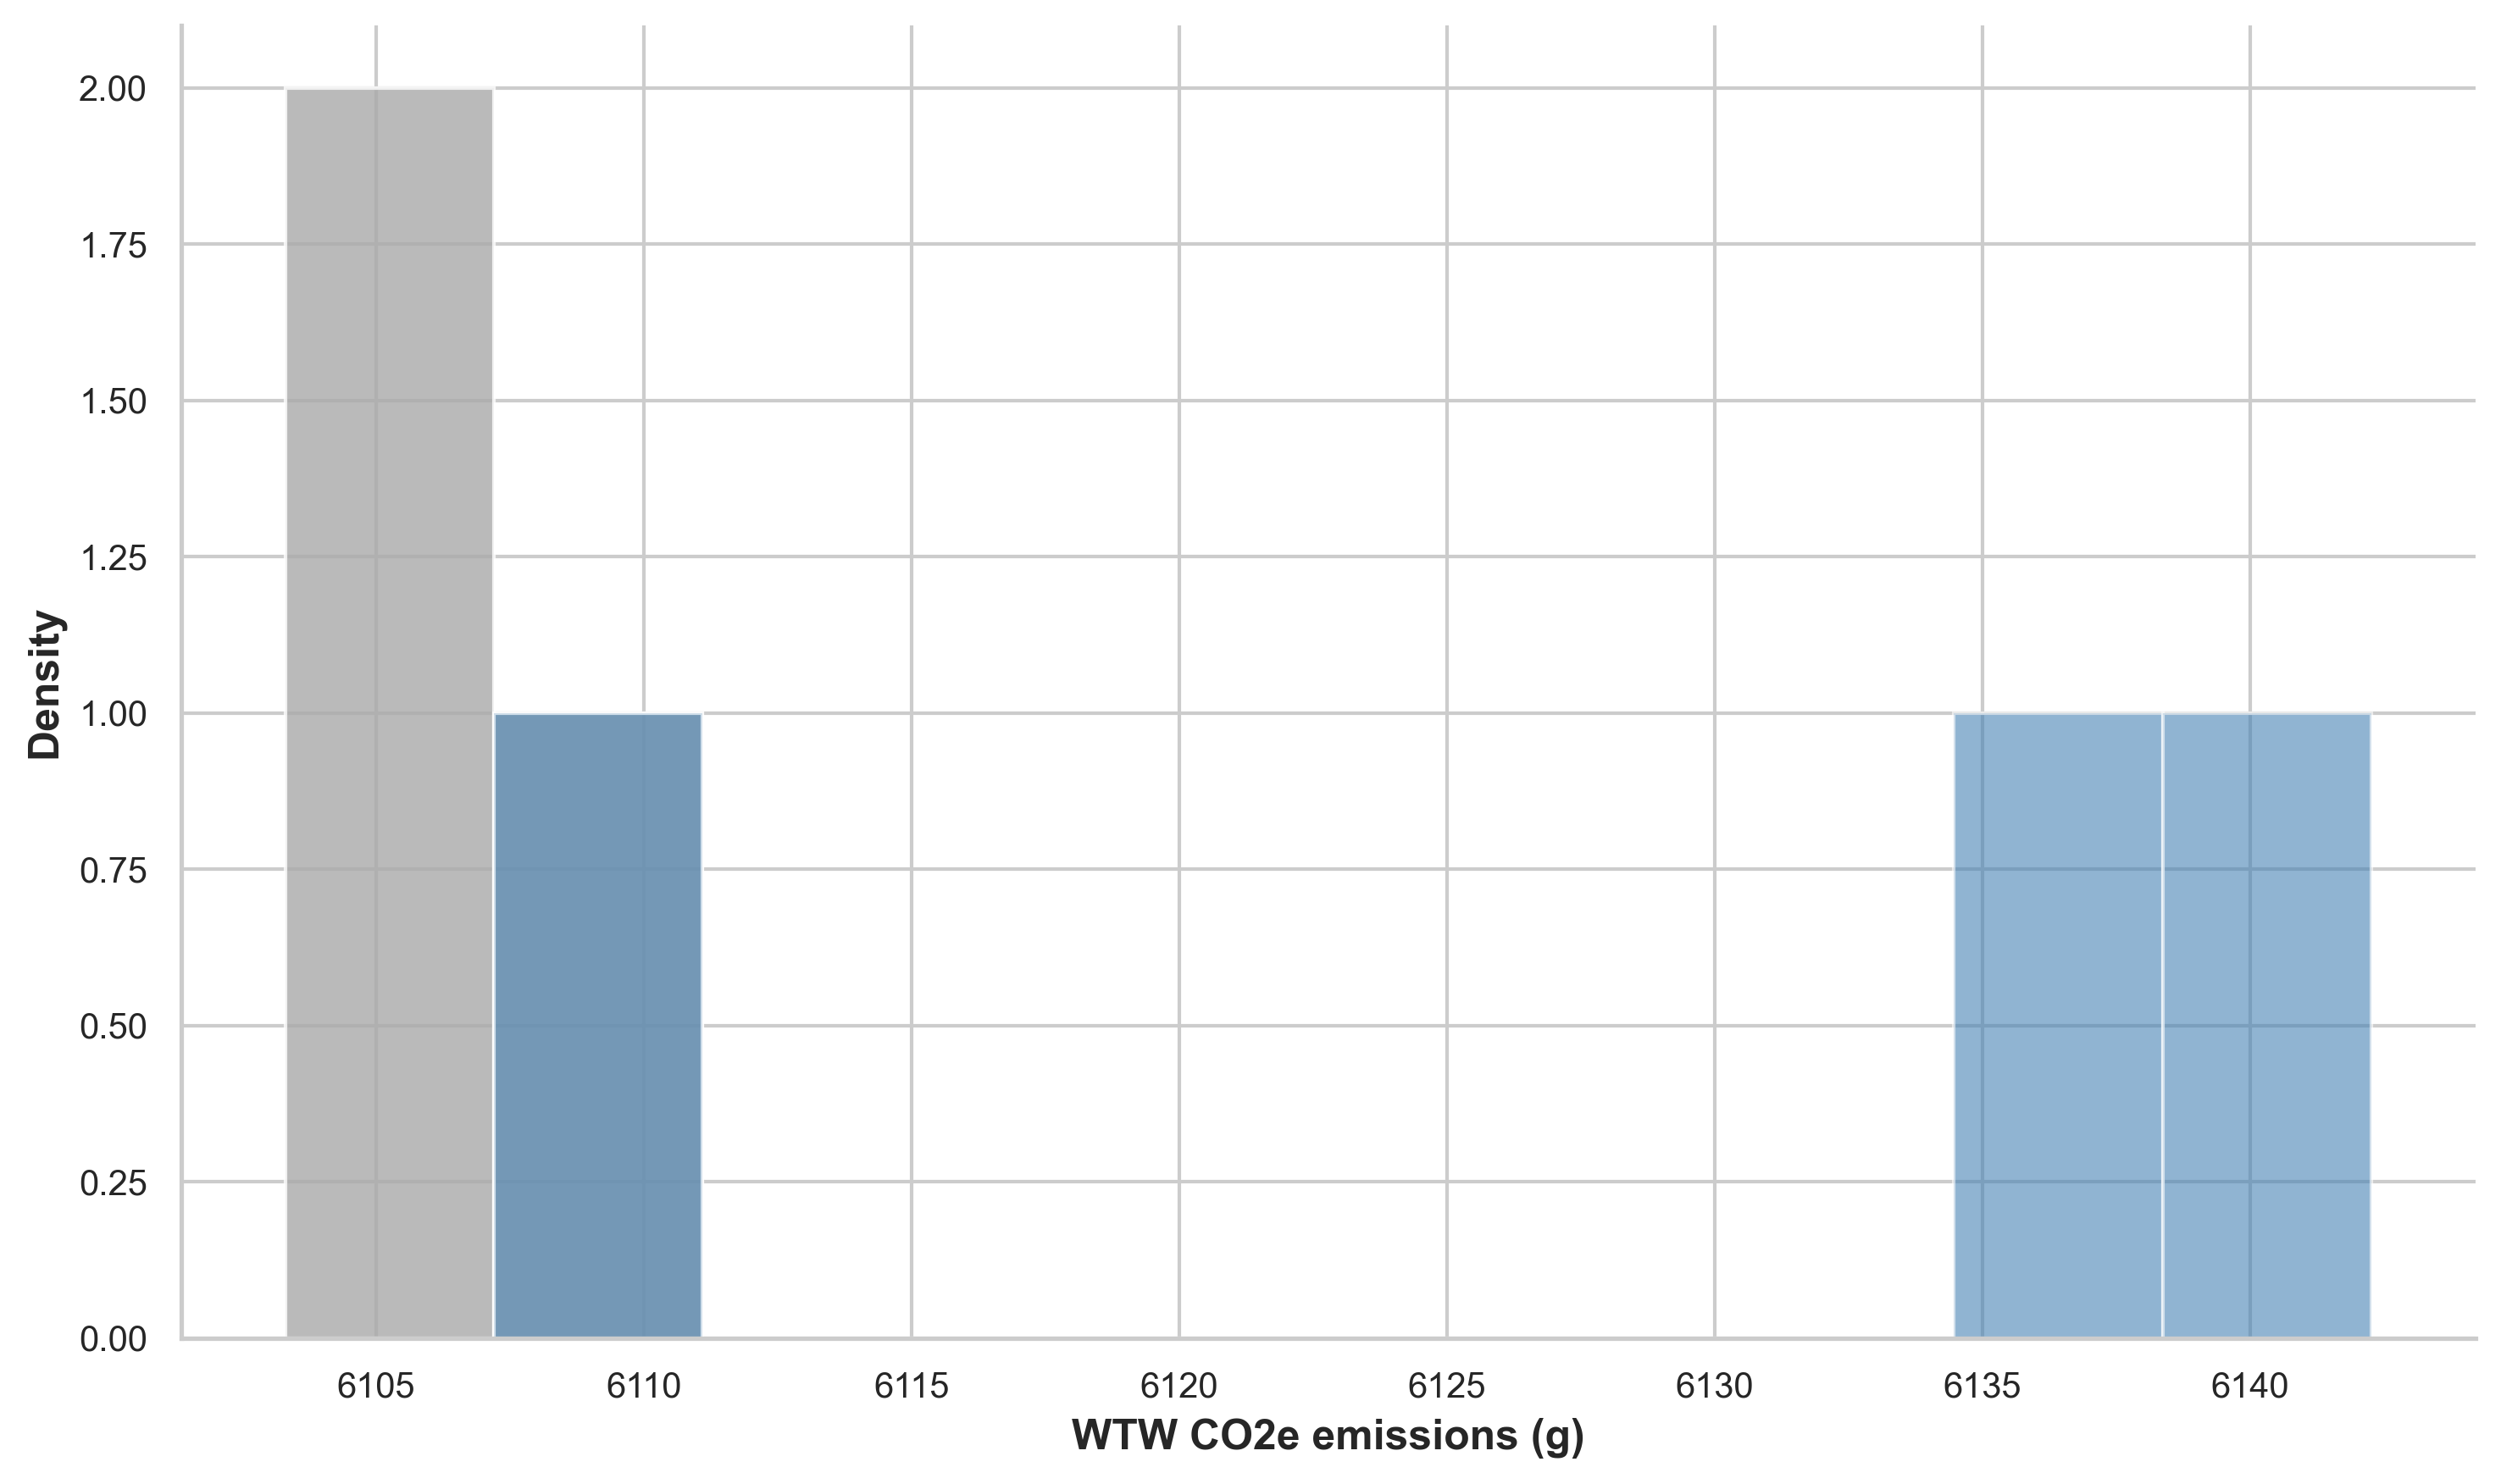

In [161]:
metric = pollutants.CO2e
plot_stat_comparison_two_groups(
    no_policy_summary=np.array(all_scenario_emissions['basic'][metric]),
    car_summary=np.array(all_scenario_emissions['van'][metric]),
    xlabel='WTW CO2e emissions (g)',
)

## Air quality

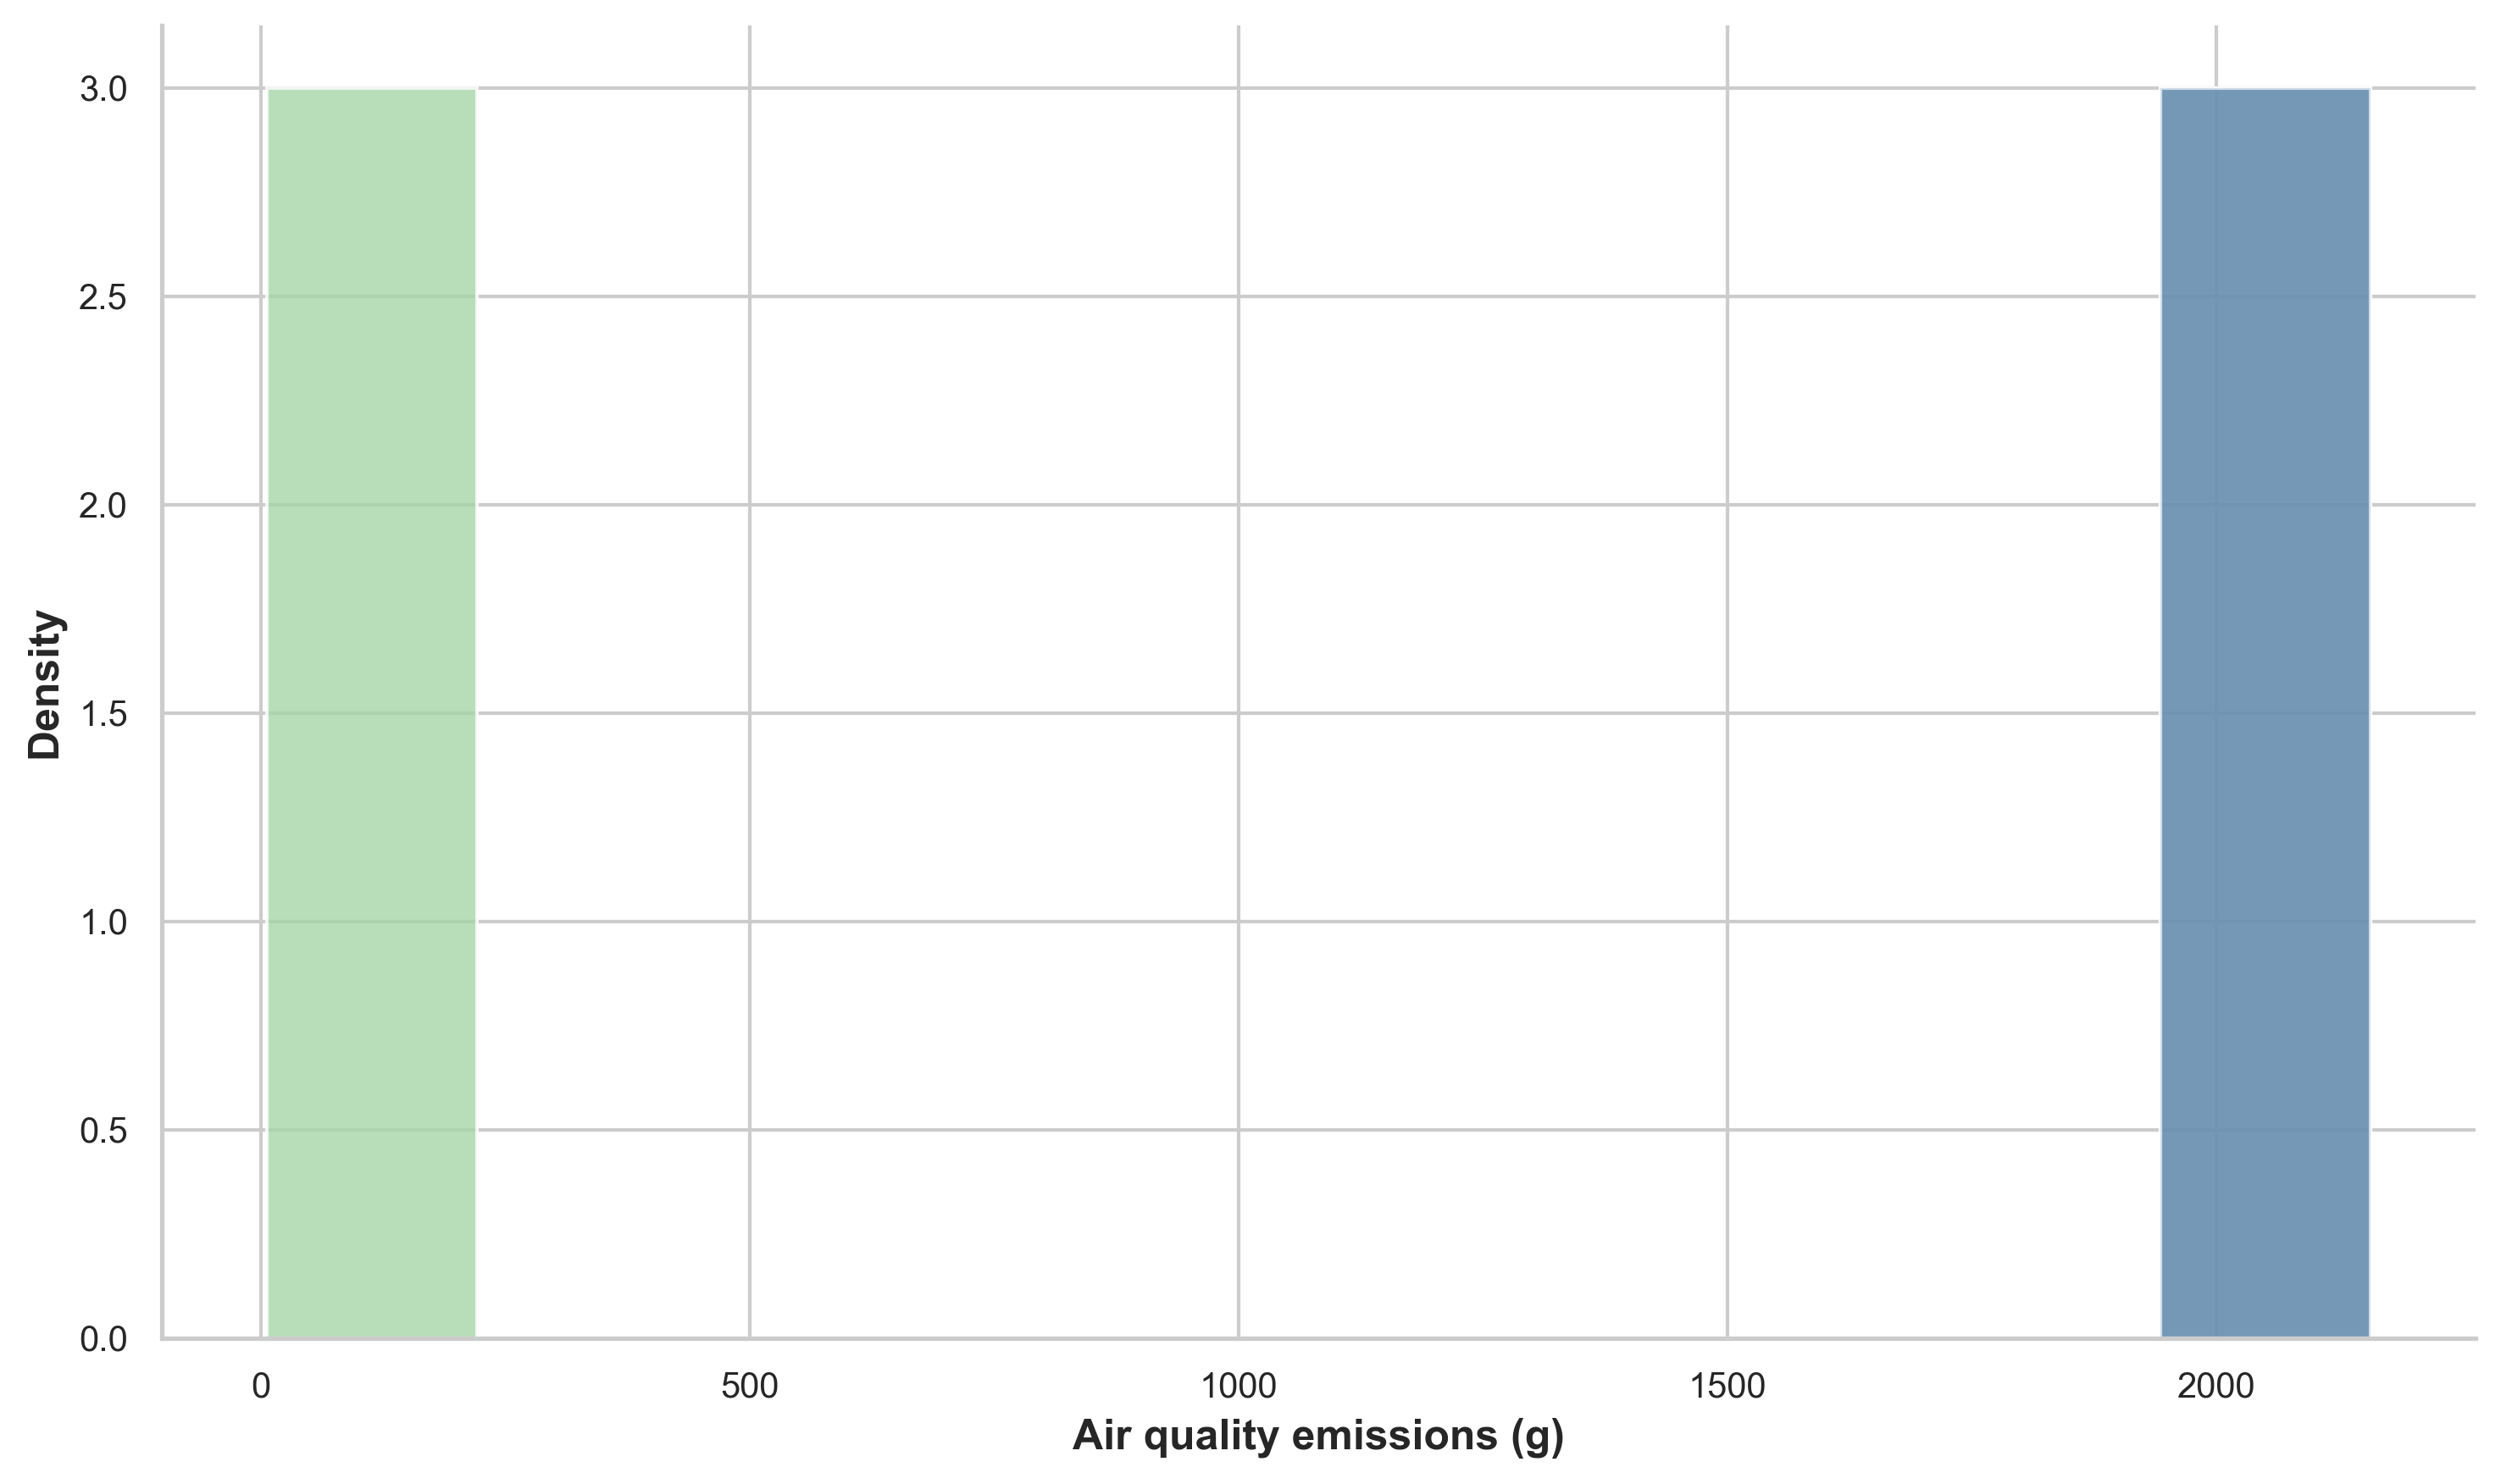

In [162]:
metric = 'air_quality_pollutants'
plot_stat_comparison(
    no_policy_summary=np.array(all_scenario_emissions['basic'][metric]),
    car_summary=np.array(all_scenario_emissions['van'][metric]),
    bike_summary=np.array(all_scenario_emissions['cb'][metric]),
    xlabel='Air quality emissions (g)',
)

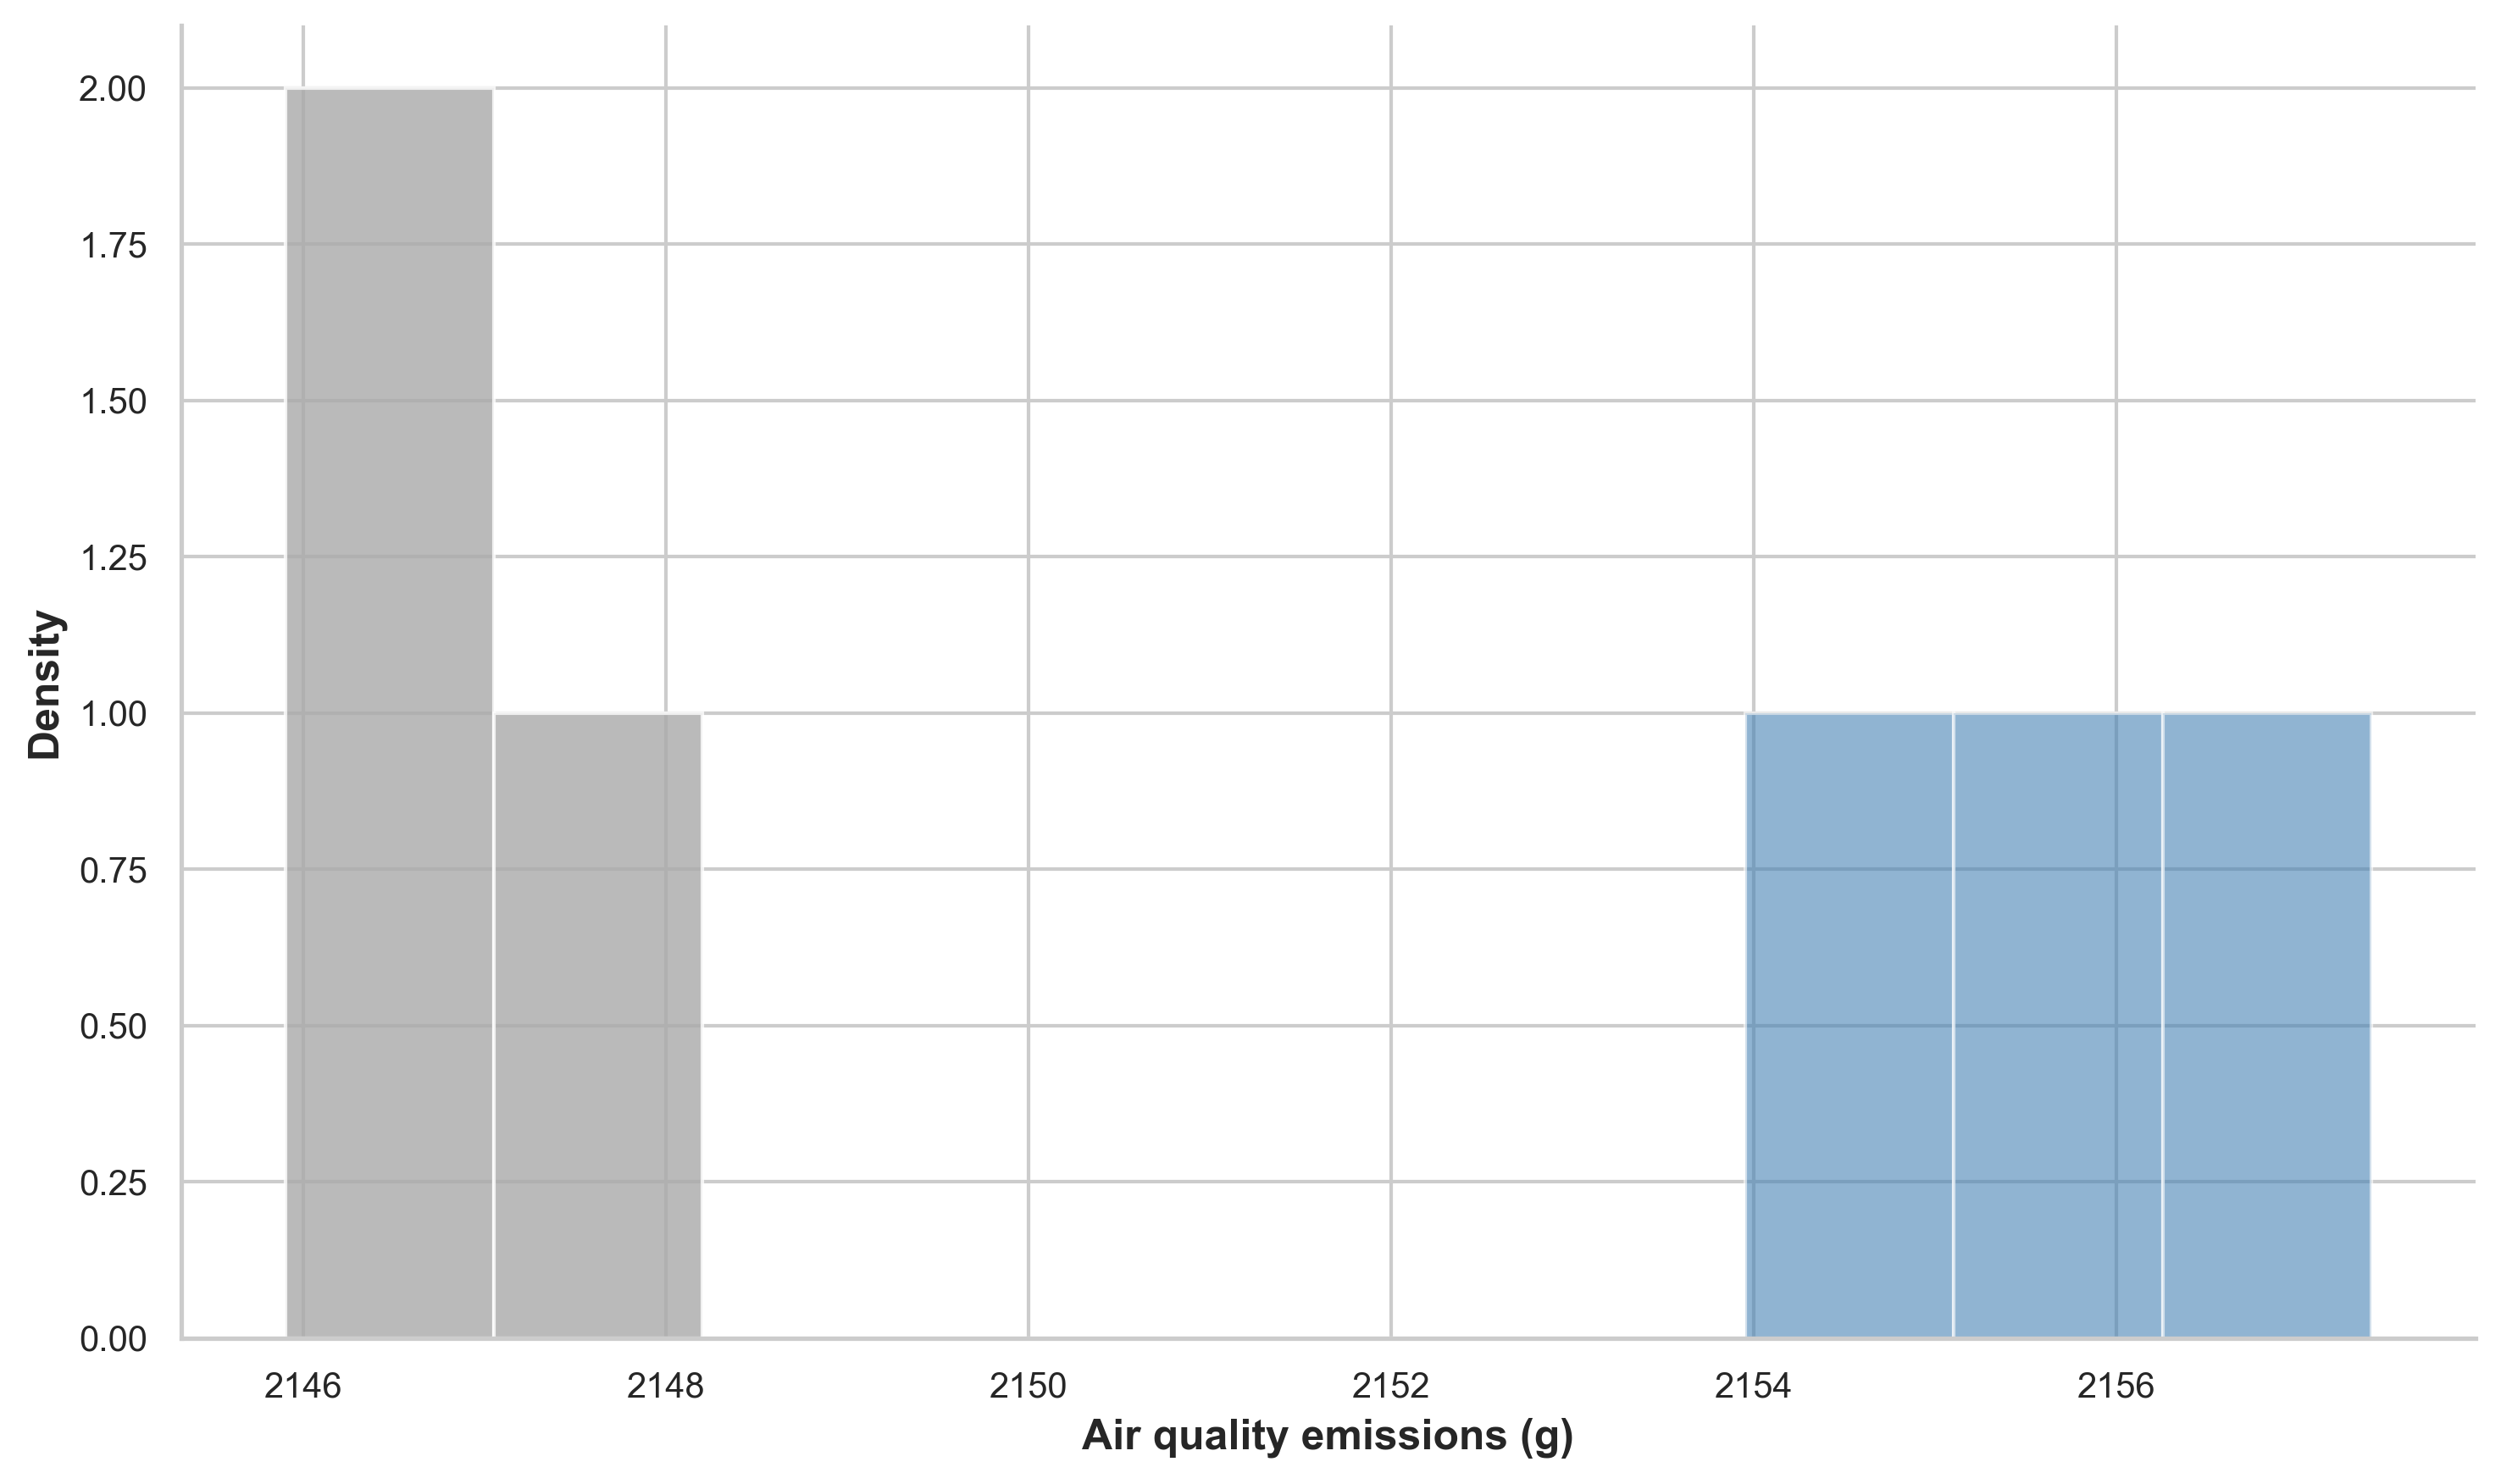

In [163]:
metric = 'air_quality_pollutants'
plot_stat_comparison_two_groups(
    no_policy_summary=np.array(all_scenario_emissions['basic'][metric]),
    car_summary=np.array(all_scenario_emissions['van'][metric]),
    xlabel='Air quality emissions (g)',
)

# Output 

In [41]:
link_co2e.to_csv(output_path+van_scenario_outputs+'link_co2e.csv', index=True, sep=';', encoding='utf-8-sig')

# Test

In [178]:
emission_events_df = read_matsim_events_as_df(root_path+scenario_kw+'output_events.xml.gz', 'warmEmissionEvent')
pollutants_by_link_dict = {}
for pollutant in pollutants.POLLUTANTS:
    if pollutant in events_df.columns:
        pollutant_by_link = events_df.pivot_table(index='linkId',
                                                    columns='type',
                                                    values=pollutant,
                                                    aggfunc='sum')
        pollutant_by_link = pollutant_by_link.fillna(0)
        pollutant_by_link['sum'] = pollutant_by_link[['warmEmissionEvent']].sum(axis=1)
    pollutants_by_link_dict[pollutant] = pollutant_by_link
emission_summary_statistics = emission_anls.get_summary_statistics(pollutants_by_link_dict)

In [182]:
cold_emission_events_df = read_matsim_events_as_df(root_path+scenario_kw+'output_events.xml.gz', 'coldEmissionEvent')
cold_emission_events_df

,CO2e,NMHC,FC_MJ,CO2_rep,PM2_5,PN,type,CO2_TOTAL,linkId,NO2,...,Pb,CH4,CO,Benzene,FC,NOx,time,PM,vehicleId,BC_exhaust
0,193.729813,4.010652,2.217966,154.470078,0.0,0.0,coldEmissionEvent,161.471848,27566523_11,0.015243,...,0.0,0.232077,29.526291,0.288930,52.346039,0.304852,0.0,0.0,freight_carrier_0_veh_carrier0_Van_1_1,0.0
1,14.704374,0.729555,0.161088,11.218976,0.0,0.0,coldEmissionEvent,11.727507,27566523_11,0.010862,...,0.0,0.042216,3.396111,0.052558,3.801830,0.217235,1.0,0.0,freight_carrier_0_veh_carrier0_Van_1_1,0.0
2,14.704374,0.729555,0.161088,11.218976,0.0,0.0,coldEmissionEvent,11.727507,27566523_11,0.010862,...,0.0,0.042216,3.396111,0.052558,3.801830,0.217235,2.0,0.0,freight_carrier_0_veh_carrier0_Van_1_1,0.0
3,14.704374,0.729555,0.161088,11.218976,0.0,0.0,coldEmissionEvent,11.727507,27566523_11,0.010862,...,0.0,0.042216,3.396111,0.052558,3.801830,0.217235,3.0,0.0,freight_carrier_0_veh_carrier0_Van_1_1,0.0
4,14.704374,0.729555,0.161088,11.218976,0.0,0.0,coldEmissionEvent,11.727507,27566523_11,0.010862,...,0.0,0.042216,3.396111,0.052558,3.801830,0.217235,4.0,0.0,freight_carrier_0_veh_carrier0_Van_1_1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,14.704374,0.729555,0.161088,11.218976,0.0,0.0,coldEmissionEvent,11.727507,314629121_11,0.010862,...,0.0,0.042216,3.396111,0.052558,3.801830,0.217235,8908.0,0.0,freight_carrier_0_veh_carrier0_Van_1_1,0.0
408,14.704374,0.729555,0.161088,11.218976,0.0,0.0,coldEmissionEvent,11.727507,724014587_r_0,0.010862,...,0.0,0.042216,3.396111,0.052558,3.801830,0.217235,8916.0,0.0,freight_carrier_0_veh_carrier0_Van_1_1,0.0
409,14.704374,0.729555,0.161088,11.218976,0.0,0.0,coldEmissionEvent,11.727507,124190277_r_4-124190277_r_5,0.010862,...,0.0,0.042216,3.396111,0.052558,3.801830,0.217235,8954.0,0.0,freight_carrier_0_veh_carrier0_Van_1_1,0.0
410,14.704374,0.729555,0.161088,11.218976,0.0,0.0,coldEmissionEvent,11.727507,319454046_r_0,0.010862,...,0.0,0.042216,3.396111,0.052558,3.801830,0.217235,8975.0,0.0,freight_carrier_0_veh_carrier0_Van_1_1,0.0


In [188]:
def filter_incorrect_cold_emission_events(cold_emission_events_df):
    incorrect_records_idx = []
    previous_time = 0
    for idx, row in cold_emission_events_df.iterrows():
        if idx == 0:
            previous_time = row['time']
            continue
        else:
            current_time = row['time']
            if current_time-previous_time == 1:
                incorrect_records_idx.append(idx)
            else:
                pass
            previous_time = current_time
    return incorrect_records_idx, cold_emission_events_df.query('index not in @incorrect_records_idx')

In [192]:
filtered_cold_emission_events = filter_incorrect_cold_emission_events(cold_emission_events_df)[1]
filtered_cold_emission_events

,CO2e,NMHC,FC_MJ,CO2_rep,PM2_5,PN,type,CO2_TOTAL,linkId,NO2,...,Pb,CH4,CO,Benzene,FC,NOx,time,PM,vehicleId,BC_exhaust
0,193.729813,4.010652,2.217966,154.470078,0.0,0.0,coldEmissionEvent,161.471848,27566523_11,0.015243,...,0.0,0.232077,29.526291,0.288930,52.346039,0.304852,0.0,0.0,freight_carrier_0_veh_carrier0_Van_1_1,0.0
106,5.565277,0.000000,0.065683,4.574462,0.0,0.0,coldEmissionEvent,4.781811,23707244_r_0,0.001121,...,0.0,0.000000,0.000000,0.000000,1.550170,0.022427,246.0,0.0,freight_carrier_0_veh_carrier0_Van_1_1,0.0
107,14.704374,0.729555,0.161088,11.218976,0.0,0.0,coldEmissionEvent,11.727507,3991636_0,0.010862,...,0.0,0.042216,3.396111,0.052558,3.801830,0.217235,422.0,0.0,freight_carrier_0_veh_carrier0_Van_1_1,0.0
108,14.704374,0.729555,0.161088,11.218976,0.0,0.0,coldEmissionEvent,11.727507,305434712_r_1,0.010862,...,0.0,0.042216,3.396111,0.052558,3.801830,0.217235,435.0,0.0,freight_carrier_0_veh_carrier0_Van_1_1,0.0
109,5.565277,0.000000,0.065683,4.574462,0.0,0.0,coldEmissionEvent,4.781811,123929457_3,0.001121,...,0.0,0.000000,0.000000,0.000000,1.550170,0.022427,586.0,0.0,freight_carrier_0_veh_carrier0_Van_1_1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,14.704374,0.729555,0.161088,11.218976,0.0,0.0,coldEmissionEvent,11.727507,314629121_11,0.010862,...,0.0,0.042216,3.396111,0.052558,3.801830,0.217235,8908.0,0.0,freight_carrier_0_veh_carrier0_Van_1_1,0.0
408,14.704374,0.729555,0.161088,11.218976,0.0,0.0,coldEmissionEvent,11.727507,724014587_r_0,0.010862,...,0.0,0.042216,3.396111,0.052558,3.801830,0.217235,8916.0,0.0,freight_carrier_0_veh_carrier0_Van_1_1,0.0
409,14.704374,0.729555,0.161088,11.218976,0.0,0.0,coldEmissionEvent,11.727507,124190277_r_4-124190277_r_5,0.010862,...,0.0,0.042216,3.396111,0.052558,3.801830,0.217235,8954.0,0.0,freight_carrier_0_veh_carrier0_Van_1_1,0.0
410,14.704374,0.729555,0.161088,11.218976,0.0,0.0,coldEmissionEvent,11.727507,319454046_r_0,0.010862,...,0.0,0.042216,3.396111,0.052558,3.801830,0.217235,8975.0,0.0,freight_carrier_0_veh_carrier0_Van_1_1,0.0


In [179]:
emission_summary_statistics

,pollutant,sum
0,CH4,2.072078e-01
1,CO2e,0.000000e+00
2,NMHC,3.108116e-01
3,N2O,5.661342e-02
4,PM2_5_non_exhaust,5.661342e-02
5,SO2,5.761203e-02
6,Pb,0.000000e+00
7,CO,3.891240e+01
8,CO2_rep,1.141798e+04
9,PM2_5,0.000000e+00


In [174]:
emission_summary_statistics

,pollutant,sum
0,CH4,1.732564e+01
1,CO2e,6.136698e+03
2,NMHC,2.961436e+02
3,N2O,5.661342e-02
4,PM2_5_non_exhaust,0.000000e+00
5,SO2,8.128849e-02
6,Pb,0.000000e+00
7,CO,1.426883e+03
8,CO2_rep,1.611036e+04
9,PM2_5,0.000000e+00
